# Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import copy
from collections import deque
import random

# Network

In [2]:
class network(nn.Module):
    def __init__(self, inputs, hidden, non_linearity):
        super(network, self).__init__()
        self.inputs = inputs
        self.hidden = hidden
        self.outputs = 1
        self.non_linearity = non_linearity
        self.fc1 = nn.Linear(self.inputs,self.hidden)
        self.fc2 = nn.Linear(self.hidden,self.outputs)
    
    def forward(self, x):
        x = self.non_linearity(self.fc1(x))
        x = self.non_linearity(self.fc2(x))
        return x
    
    def increase_capacity(self, increment):
        """Adds neurons to the hidden layer. The number of neurons to be added is specified by the increment variable."""
        # Save weight and biases
        old_weight_fc1 = self.fc1.weight.data
        old_bias_fc1 = self.fc1.bias.data 
        
        old_weight_fc2 = self.fc2.weight.data
        old_bias_fc2 = self.fc2.bias.data

        # Increment the number of hidden nodes
        self.hidden += increment
        
        # Reinstate old weights and biases
        self.fc1 = nn.Linear(self.inputs, self.hidden)
        self.fc1.weight.data[:-increment,:] = old_weight_fc1
        self.fc1.bias.data[:-increment] = old_bias_fc1
        
        self.fc2 = nn.Linear(self.hidden, self.outputs)
        self.fc2.weight.data[:,:-increment] = old_weight_fc2
        
        # Number of outputs does not change
        self.fc2.bias.data = old_bias_fc2
    
    def decrease_capacity(self, decrement):
        """Removes the most recently added neurons from the hidden layer. The number of neurons to be removed is specified by the decrement variable."""
        # Save weight and biases
        old_weight_fc1 = self.fc1.weight.data
        old_bias_fc1 = self.fc1.bias.data 
        
        old_weight_fc2 = self.fc2.weight.data
        old_bias_fc2 = self.fc2.bias.data

        # Decrement the number of hidden nodes
        self.hidden -= decrement
        
        # Reinstate old weights and biases
        self.fc1 = nn.Linear(self.inputs, self.hidden)
        self.fc1.weight.data = old_weight_fc1[:-decrement,:]
        self.fc1.bias.data = old_bias_fc1[:-decrement]
        
        self.fc2 = nn.Linear(self.hidden, self.outputs)
        self.fc2.weight.data = old_weight_fc2[:,:-decrement]
        
        # Number of outputs does not change
        self.fc2.bias.data = old_bias_fc2
        
    def decrease_capacity_initial(self, decrement):
        """Removes the least recently added neurons from the hidden layer. The number of neurons to be removed is specified by the decrement variable."""
        # Save weight and biases
        old_weight_fc1 = self.fc1.weight.data
        old_bias_fc1 = self.fc1.bias.data 
        
        old_weight_fc2 = self.fc2.weight.data
        old_bias_fc2 = self.fc2.bias.data
        
        # Decrement the number of hidden nodes
        self.hidden -= decrement
        
        # Reinstate old weights and biases
        self.fc1 = nn.Linear(self.inputs, self.hidden)
        self.fc1.weight.data = old_weight_fc1[decrement:,:]
        self.fc1.bias.data = old_bias_fc1[decrement:]
        
        self.fc2 = nn.Linear(self.hidden, self.outputs)
        self.fc2.weight.data = old_weight_fc2[:,decrement:]
        
        # Number of outputs does not change
        self.fc2.bias.data = old_bias_fc2

# Input and target tensors

In [3]:
Xs_OR = torch.tensor([[0,0,0],[0,1,0],[1,0,0],[1,1,0]], dtype=torch.float)
Ys_OR = torch.tensor([[0],[1],[1],[1]], dtype=torch.float)

Xs_XOR = torch.tensor([[0,0,1],[0,1,1],[1,0,1],[1,1,1]], dtype=torch.float)
Ys_XOR = torch.tensor([[0],[1],[1],[0]], dtype=torch.float)

The following cell contains code used for a failed experiment where Adam learning rates of preexisiting neurons are kept when adding neurons instead of initialising a new optimizer.

In [4]:
def increase_capacity_keep_lr(network, capacity, optimizer, device, lr):
    # Store old ids
    old_ids = [id(p) for p in network.parameters()]
    old_param_sizes = [p.size() for p in network.parameters()]

    network.increase_capacity(capacity)

    # Store new ids
    new_ids = [id(p) for p in network.parameters()]
    new_param_sizes = [p.size() for p in network.parameters()]

    # Store old state 
    opt_state_dict = optimizer.state_dict()
    
#     if opt_state_dict['state'] == {}:
#         optimizer = torch.optim.Adam(network.parameters(), lr=lr)
#         return net, optimizer
        
    for old_id, new_id, new_param_size, old_param_size in zip(old_ids, new_ids, new_param_sizes, old_param_sizes):
        # Store step, and exp_avgs
        step = opt_state_dict['state'][old_id]['step']
        old_exp_avg = opt_state_dict['state'][old_id]['exp_avg']
        old_exp_avg_sq = opt_state_dict['state'][old_id]['exp_avg_sq']

        exp_avg = torch.zeros(new_param_size)
        exp_avg_sq = torch.zeros(new_param_size)
        # Extend exp_avgs to new shape depending on wether param is bias or weight
        if exp_avg.dim()>1:
            # Weights
            exp_avg[0:old_param_size[0],0:old_param_size[1]] = old_exp_avg
            exp_avg_sq[0:old_param_size[0],0:old_param_size[1]] = old_exp_avg_sq
        else:
            # Biases/last layer
            exp_avg[0:old_param_size[0]] = old_exp_avg
            exp_avg_sq[0:old_param_size[0]] = old_exp_avg_sq
        
        # Delete old id from state_dict and update new params and new id
        del opt_state_dict['state'][old_id]
        opt_state_dict['state'][new_id] = {
            'step': step,
            'exp_avg': exp_avg,
            'exp_avg_sq': exp_avg_sq.to(device)
        }
        opt_state_dict['param_groups'][0]['params'].remove(old_id)
        opt_state_dict['param_groups'][0]['params'].append(new_id)
    opt_state_dict['param_groups'][0]['lr'] = lr
    network.to(device)
    optimizer = torch.optim.Adam(network.parameters())
    optimizer.load_state_dict(opt_state_dict)
    return network, optimizer

How long does it take to train OR and XOR in the target task setting? For two networks only either of the problems is sampled.

In [5]:
def train_OR(iters, net, optim, criterion):
    for epoch in range(iters):
        r = np.random.choice([0,1,2,3],1)
        for X, Y in zip(Xs_OR[r], Ys_OR[r]):
            optim.zero_grad()
            output = net(X.view(1,-1))
            loss = criterion(output,Y.view(1,-1))
            loss.backward()
            optim.step()
            with torch.no_grad():
                if 1.0/(1.0+criterion(net(Xs_OR),Ys_OR)) > 1.0 - 0.001:
                    return epoch, 1.0/(1.0+criterion(net(Xs_OR),Ys_OR)), 1.0/(1.0+criterion(net(Xs_XOR),Ys_XOR))
    return epoch, 1.0/(1.0+criterion(net(Xs_OR),Ys_OR)), 1.0/(1.0+criterion(net(Xs_XOR),Ys_XOR))

def train_XOR(iters, net, optim, criterion):
    for epoch in range(iters):
        r = np.random.choice([0,1,2,3],1)
        for X, Y in zip(Xs_XOR[r], Ys_XOR[r]):
            optim.zero_grad()
            output = net(X.view(1,-1))
            loss = criterion(output,Y.view(1,-1))
            loss.backward()
            optim.step()
            with torch.no_grad():
                if 1.0/(1.0+criterion(net(Xs_XOR),Ys_XOR)) > 1.0 - 0.001:
                    return epoch, 1.0/(1.0+criterion(net(Xs_OR),Ys_OR)), 1.0/(1.0+criterion(net(Xs_XOR),Ys_XOR))
    return epoch, 1.0/(1.0+criterion(net(Xs_OR),Ys_OR)), 1.0/(1.0+criterion(net(Xs_XOR),Ys_XOR))

epochs = 0
OR_losses = 0.0
XOR_losses = 0.0
seeds = 100
for seed in tqdm_notebook(range(seeds)):
    torch.manual_seed(seed)
    net = network(3,3, torch.sigmoid)
    optim = torch.optim.Adam(net.parameters(), lr=0.05)
    criterion = nn.MSELoss()
    epoch, OR_loss, XOR_loss = train_XOR(8000, net, optim, criterion)
    epochs += epoch
    OR_losses += OR_loss.item()
    XOR_losses += XOR_loss.item()
    
print('Average epochs: ', epochs/seeds)
print('Average OR Loss: ', OR_losses/seeds)
print('Average XOR Loss: ', XOR_losses/seeds)
print('Average Loss: ', np.mean([OR_losses/seeds, XOR_losses/seeds]))
print('Std Loss: ', np.std([OR_losses/seeds, XOR_losses/seeds]))
print('Fitness: ', np.mean([OR_losses/seeds, XOR_losses/seeds]) - np.std([OR_losses/seeds, XOR_losses/seeds]))

epochs = 0
OR_losses = 0.0
XOR_losses = 0.0
seeds = 100
for seed in tqdm_notebook(range(seeds)):
    torch.manual_seed(seed)
    net = network(3,3, torch.sigmoid)
    optim = torch.optim.Adam(net.parameters(), lr=0.05)
    criterion = nn.MSELoss()
    epoch, OR_loss, XOR_loss = train_OR(8000, net, optim, criterion)
    epochs += epoch
    OR_losses += OR_loss.item()
    XOR_losses += XOR_loss.item()
    
print('Average epochs: ', epochs/seeds)
print('Average OR Loss: ', OR_losses/seeds)
print('Average XOR Loss: ', XOR_losses/seeds)
print('Average Loss: ', np.mean([OR_losses/seeds, XOR_losses/seeds]))
print('Std Loss: ', np.std([OR_losses/seeds, XOR_losses/seeds]))
print('Fitness: ', np.mean([OR_losses/seeds, XOR_losses/seeds]) - np.std([OR_losses/seeds, XOR_losses/seeds]))

HBox(children=(IntProgress(value=0), HTML(value='')))


Average epochs:  3227.48
Average OR Loss:  0.7615322530269623
Average XOR Loss:  0.9850025629997253
Average Loss:  0.8732674080133438
Std Loss:  0.11173515498638154
Fitness:  0.7615322530269623


HBox(children=(IntProgress(value=0), HTML(value='')))


Average epochs:  648.57
Average OR Loss:  0.9990016937255859
Average XOR Loss:  0.8042533046007156
Average Loss:  0.9016274991631508
Std Loss:  0.09737419456243512
Fitness:  0.8042533046007156


How long does it take to train OR and XOR in the target task setting? For two networks only either of the problems is sampled. After 4000 steps the number of neurons is increased from 1 to 2

In [6]:
def train_OR(iters, net, optim, criterion):
    for epoch in range(iters):
        r = np.random.choice([0,1,2,3],1)
        for X, Y in zip(Xs_OR[r], Ys_OR[r]):
            optim.zero_grad()
            output = net(X.view(1,-1))
            loss = criterion(output,Y.view(1,-1))
            loss.backward()
            optim.step()
            with torch.no_grad():
                if 1.0/(1.0+criterion(net(Xs_OR),Ys_OR)) > 1.0 - 0.001:
                    
                    return epoch, 1.0/(1.0+criterion(net(Xs_OR),Ys_OR)), 1.0/(1.0+criterion(net(Xs_XOR),Ys_XOR)), net, optim
    return epoch, 1.0/(1.0+criterion(net(Xs_OR),Ys_OR)), 1.0/(1.0+criterion(net(Xs_XOR),Ys_XOR)), net, optim

def train_XOR(iters, net, optim, criterion):
    for epoch in range(iters):
        r = np.random.choice([0,1,2,3],1)
        for X, Y in zip(Xs_XOR[r], Ys_XOR[r]):
            optim.zero_grad()
            output = net(X.view(1,-1))
            loss = criterion(output,Y.view(1,-1))
            loss.backward()
            optim.step()
            with torch.no_grad():
                if 1.0/(1.0+criterion(net(Xs_XOR),Ys_XOR)) > 1.0 - 0.001:
                    
                    return epoch, 1.0/(1.0+criterion(net(Xs_OR),Ys_OR)), 1.0/(1.0+criterion(net(Xs_XOR),Ys_XOR)), net, optim
    return epoch, 1.0/(1.0+criterion(net(Xs_OR),Ys_OR)), 1.0/(1.0+criterion(net(Xs_XOR),Ys_XOR)), net, optim

epochs = 0
OR_losses = 0.0
XOR_losses = 0.0
seeds = 100
for seed in tqdm_notebook(range(seeds)):
    torch.manual_seed(seed)
    net = network(3,1, torch.sigmoid)
    optim = torch.optim.Adam(net.parameters(), lr=0.05)
    criterion = nn.MSELoss()
    
    epoch, OR_loss, XOR_loss, net, optim = train_XOR(4000, net, optim, criterion)
    epochs += epoch
    net.increase_capacity(2)
    optim = torch.optim.Adam(net.parameters(), lr=0.05)
    epoch, OR_loss, XOR_loss, net, optim = train_XOR(4000, net, optim, criterion)
    epochs += epoch
    OR_losses += OR_loss
    XOR_losses += XOR_loss
    
print('Average epochs: ', epochs/seeds)
print('Average OR Loss: ', OR_losses/seeds)
print('Average XOR Loss: ', XOR_losses/seeds)
print('Average Loss: ', np.mean([OR_losses/seeds, XOR_losses/seeds]))
print('Std Loss: ', np.std([OR_losses/seeds, XOR_losses/seeds]))
print('Fitness: ', np.mean([OR_losses/seeds, XOR_losses/seeds]) - np.std([OR_losses/seeds, XOR_losses/seeds]))

epochs = 0
OR_losses = 0.0
XOR_losses = 0.0
seeds = 100
for seed in tqdm_notebook(range(seeds)):
    torch.manual_seed(seed)
    net = network(3,1, torch.sigmoid)
    optim = torch.optim.Adam(net.parameters(), lr=0.05)
    criterion = nn.MSELoss()
    epoch, OR_loss, XOR_loss, net, optim = train_OR(4000, net, optim, criterion)
    epochs += epoch
    net.increase_capacity(2)
    optim = torch.optim.Adam(net.parameters(), lr=0.05)
    epoch, OR_loss, XOR_loss, net, optim = train_OR(4000, net, optim, criterion)
    epochs += epoch
    OR_losses += OR_loss
    XOR_losses += XOR_loss
    
print('Average epochs: ', epochs/seeds)
print('Average OR Loss: ', OR_losses/seeds)
print('Average XOR Loss: ', XOR_losses/seeds)
print('Average Loss: ', np.mean([OR_losses/seeds, XOR_losses/seeds]))
print('Std Loss: ', np.std([OR_losses/seeds, XOR_losses/seeds]))
print('Fitness: ', np.mean([OR_losses/seeds, XOR_losses/seeds]) - np.std([OR_losses/seeds, XOR_losses/seeds]))

HBox(children=(IntProgress(value=0), HTML(value='')))


Average epochs:  5419.51
Average OR Loss:  tensor(0.6980)
Average XOR Loss:  tensor(0.9990)
Average Loss:  0.84851396
Std Loss:  0.15048683
Fitness:  0.69802713


HBox(children=(IntProgress(value=0), HTML(value='')))


Average epochs:  1356.67
Average OR Loss:  tensor(0.9990)
Average XOR Loss:  tensor(0.8056)
Average Loss:  0.9023299
Std Loss:  0.09671563
Fitness:  0.8056143


# Curriculum with fixed architecture

------------
Initial Capacity:  1
Added Capacity:  0
OR probability:  0.9


HBox(children=(IntProgress(value=0), HTML(value='')))


Epochs average: 6081.24
OR Fitness average: tensor(0.9385, grad_fn=<DivBackward0>)
XOR Fitness average: tensor(0.8538, grad_fn=<DivBackward0>)
OR Fitness average after decrease: 0.0
XOR Fitness average after decrease: 0.0
Average Fitness: tensor(0.8961, grad_fn=<DivBackward0>)
Standard Deviation Fitness: 0.04236186981201173
Fitness : tensor(0.8538, grad_fn=<SubBackward0>)
Percentage reach threshold:  0
Common Weight change fc1:  3.512546944618225
Common Bias change fc1:  0.5038240110874176
Common Weight change fc2:  1.136292290687561
Common Bias change fc2:  1.6153572845458983


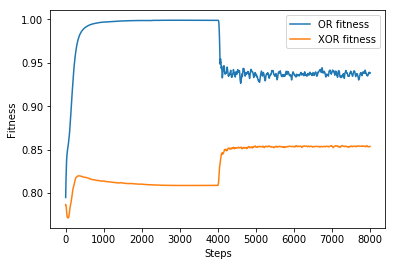

------------
Initial Capacity:  1
Added Capacity:  0
OR probability:  1.0


HBox(children=(IntProgress(value=0), HTML(value='')))


Epochs average: 5352.61
OR Fitness average: tensor(0.9178, grad_fn=<DivBackward0>)
XOR Fitness average: tensor(0.8538, grad_fn=<DivBackward0>)
OR Fitness average after decrease: 0.0
XOR Fitness average after decrease: 0.0
Average Fitness: tensor(0.8858, grad_fn=<DivBackward0>)
Standard Deviation Fitness: 0.03203105926513672
Fitness : tensor(0.8538, grad_fn=<SubBackward0>)
Percentage reach threshold:  0
Common Weight change fc1:  4.257711155414581
Common Bias change fc1:  0.17620973587036132
Common Weight change fc2:  1.5341965961456299
Common Bias change fc2:  1.8125045561790467


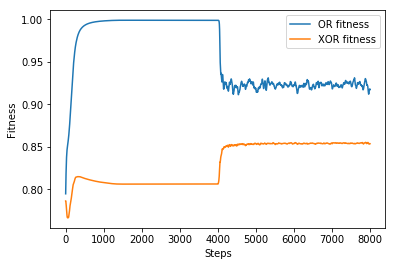

------------
Initial Capacity:  1
Added Capacity:  0
OR probability:  0.5


HBox(children=(IntProgress(value=0), HTML(value='')))


Epochs average: 8000.0
OR Fitness average: tensor(0.9764, grad_fn=<DivBackward0>)
XOR Fitness average: tensor(0.8359, grad_fn=<DivBackward0>)
OR Fitness average after decrease: 0.0
XOR Fitness average after decrease: 0.0
Average Fitness: tensor(0.9062, grad_fn=<DivBackward0>)
Standard Deviation Fitness: 0.07023097991943361
Fitness : tensor(0.8359, grad_fn=<SubBackward0>)
Percentage reach threshold:  0
Common Weight change fc1:  2.11834312915802
Common Bias change fc1:  0.8544334471225739
Common Weight change fc2:  0.8287822961807251
Common Bias change fc2:  0.397901975363493


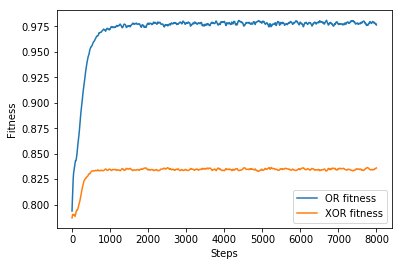

------------
Initial Capacity:  2
Added Capacity:  0
OR probability:  0.9


HBox(children=(IntProgress(value=0), HTML(value='')))


Epochs average: 5269.16
OR Fitness average: tensor(0.9375, grad_fn=<DivBackward0>)
XOR Fitness average: tensor(0.8519, grad_fn=<DivBackward0>)
OR Fitness average after decrease: tensor(0.7646, grad_fn=<DivBackward0>)
XOR Fitness average after decrease: tensor(0.7778, grad_fn=<DivBackward0>)
Average Fitness: tensor(0.8947, grad_fn=<DivBackward0>)
Standard Deviation Fitness: 0.04282615661621092
Fitness : tensor(0.8519, grad_fn=<SubBackward0>)
Percentage reach threshold:  0
Common Weight change fc1:  3.9639382123947144
Common Bias change fc1:  0.3794814115762711
Common Weight change fc2:  1.1232064974308014
Common Bias change fc2:  1.1008869069814682


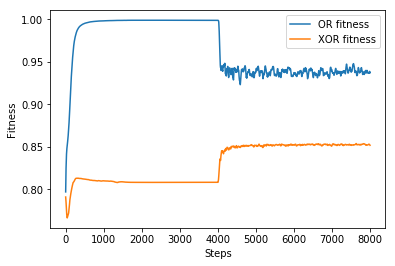

------------
Initial Capacity:  2
Added Capacity:  0
OR probability:  1.0


HBox(children=(IntProgress(value=0), HTML(value='')))


Epochs average: 4871.63
OR Fitness average: tensor(0.9316, grad_fn=<DivBackward0>)
XOR Fitness average: tensor(0.8531, grad_fn=<DivBackward0>)
OR Fitness average after decrease: tensor(0.7577, grad_fn=<DivBackward0>)
XOR Fitness average after decrease: tensor(0.7762, grad_fn=<DivBackward0>)
Average Fitness: tensor(0.8924, grad_fn=<DivBackward0>)
Standard Deviation Fitness: 0.039246520996093714
Fitness : tensor(0.8531, grad_fn=<SubBackward0>)
Percentage reach threshold:  0
Common Weight change fc1:  4.674456090927124
Common Bias change fc1:  0.3370796924829483
Common Weight change fc2:  1.3748514556884766
Common Bias change fc2:  1.2362442082166671


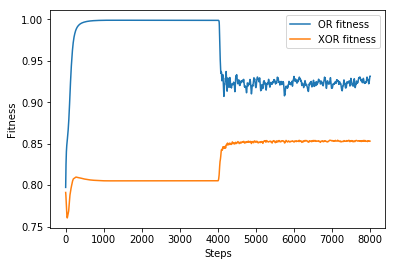

------------
Initial Capacity:  2
Added Capacity:  0
OR probability:  0.5


HBox(children=(IntProgress(value=0), HTML(value='')))


Epochs average: 7191.32
OR Fitness average: tensor(0.9862, grad_fn=<DivBackward0>)
XOR Fitness average: tensor(0.8593, grad_fn=<DivBackward0>)
OR Fitness average after decrease: tensor(0.8509, grad_fn=<DivBackward0>)
XOR Fitness average after decrease: tensor(0.7960, grad_fn=<DivBackward0>)
Average Fitness: tensor(0.9228, grad_fn=<DivBackward0>)
Standard Deviation Fitness: 0.0634827423095703
Fitness : tensor(0.8593, grad_fn=<SubBackward0>)
Percentage reach threshold:  10
Common Weight change fc1:  1.7399959437549115
Common Bias change fc1:  0.7128235648572445
Common Weight change fc2:  1.0295439493656158
Common Bias change fc2:  0.3857144766300917


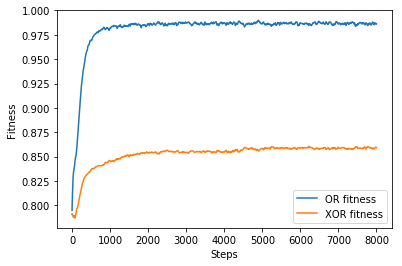

------------
Initial Capacity:  3
Added Capacity:  0
OR probability:  0.9


HBox(children=(IntProgress(value=0), HTML(value='')))


Epochs average: 4819.35
OR Fitness average: tensor(0.9444, grad_fn=<DivBackward0>)
XOR Fitness average: tensor(0.8617, grad_fn=<DivBackward0>)
OR Fitness average after decrease: tensor(0.8483, grad_fn=<DivBackward0>)
XOR Fitness average after decrease: tensor(0.8287, grad_fn=<DivBackward0>)
Average Fitness: tensor(0.9030, grad_fn=<DivBackward0>)
Standard Deviation Fitness: 0.04135551452636721
Fitness : tensor(0.8617, grad_fn=<SubBackward0>)
Percentage reach threshold:  1
Common Weight change fc1:  3.992362749576569
Common Bias change fc1:  0.7153543977811933
Common Weight change fc2:  1.2668628224730492
Common Bias change fc2:  0.7496937917172909


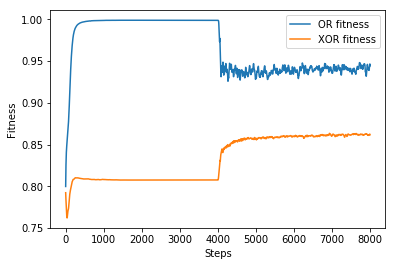

------------
Initial Capacity:  3
Added Capacity:  0
OR probability:  1.0


HBox(children=(IntProgress(value=0), HTML(value='')))


Epochs average: 4510.57
OR Fitness average: tensor(0.9064, grad_fn=<DivBackward0>)
XOR Fitness average: tensor(0.8650, grad_fn=<DivBackward0>)
OR Fitness average after decrease: tensor(0.8184, grad_fn=<DivBackward0>)
XOR Fitness average after decrease: tensor(0.8236, grad_fn=<DivBackward0>)
Average Fitness: tensor(0.8857, grad_fn=<DivBackward0>)
Standard Deviation Fitness: 0.02070816040039064
Fitness : tensor(0.8650, grad_fn=<SubBackward0>)
Percentage reach threshold:  0
Common Weight change fc1:  4.599618289470673
Common Bias change fc1:  0.4687189904227853
Common Weight change fc2:  1.4852485358715057
Common Bias change fc2:  0.9140477266907692


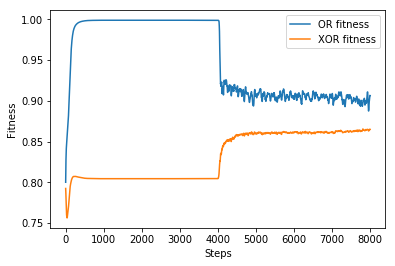

------------
Initial Capacity:  3
Added Capacity:  0
OR probability:  0.5


HBox(children=(IntProgress(value=0), HTML(value='')))


Epochs average: 5776.22
OR Fitness average: tensor(0.9916, grad_fn=<DivBackward0>)
XOR Fitness average: tensor(0.9036, grad_fn=<DivBackward0>)
OR Fitness average after decrease: tensor(0.9028, grad_fn=<DivBackward0>)
XOR Fitness average after decrease: tensor(0.8341, grad_fn=<DivBackward0>)
Average Fitness: tensor(0.9476, grad_fn=<DivBackward0>)
Standard Deviation Fitness: 0.04402191162109376
Fitness : tensor(0.9036, grad_fn=<SubBackward0>)
Percentage reach threshold:  38
Common Weight change fc1:  1.359536422342062
Common Bias change fc1:  0.7535885678976775
Common Weight change fc2:  1.2031150487065316
Common Bias change fc2:  0.6185288150981069


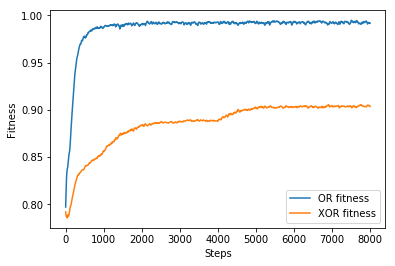

network(
  (fc1): Linear(in_features=3, out_features=3, bias=True)
  (fc2): Linear(in_features=3, out_features=1, bias=True)
)

In [7]:
def train_both(iters, p, mode, delta, net, optim):
    criterion = nn.MSELoss()
    OR_losses = []
    XOR_losses = []
    average_losses = []
    
    steps = 0
    for epoch in range(iters):
        r = np.random.choice([0,1,2,3], 1)
        if np.random.rand()<p:
            for X, Y in zip(Xs_OR[r], Ys_OR[r]):
                steps+=1
                optim.zero_grad()
                output = net(X.view(1,-1) + torch.FloatTensor(X.view(1,-1).size()).uniform_(-delta,delta))
                loss = criterion(output,Y.view(1,-1))
                
                loss.backward()
                optim.step()
                with torch.no_grad():
                    OR_loss = 1.0 / (1.0+criterion(net(Xs_OR),Ys_OR))
                    XOR_loss = 1.0 / (1.0+criterion(net(Xs_XOR),Ys_XOR))
                    average_loss = (OR_loss + XOR_loss)/2
                    
                    OR_losses.append(OR_loss)
                    XOR_losses.append(XOR_loss)
                    average_losses.append(average_loss)
                    
                    if mode==0:
                        if OR_loss > 1.0 - 0.001:
                            
                            return steps, OR_losses, XOR_losses, average_losses, net, optim
                    else:
                        if XOR_loss > 1.0 - 0.001:
                            
                            return steps, OR_losses, XOR_losses, average_losses, net, optim
        else:
            for X, Y in zip(Xs_XOR[r], Ys_XOR[r]):
                steps+=1
                optim.zero_grad()
                output = net(X.view(1,-1) + torch.FloatTensor(X.view(1,-1).size()).uniform_(-delta,delta))
                loss = criterion(output,Y.view(1,-1))
                
                loss.backward()
                optim.step()
                with torch.no_grad():
                    OR_loss = 1.0 / (1.0+criterion(net(Xs_OR),Ys_OR))
                    XOR_loss = 1.0 / (1.0+criterion(net(Xs_XOR),Ys_XOR))
                    average_loss = (OR_loss + XOR_loss)/2
                    
                    OR_losses.append(OR_loss)
                    XOR_losses.append(XOR_loss)
                    average_losses.append(average_loss)
                    
                    if mode==0:
                        if OR_loss > 1.0 - 0.001:
                            
                            return steps, OR_losses, XOR_losses, average_losses, net, optim
                    else:
                        if XOR_loss > 1.0 - 0.001:
                            
                            return steps, OR_losses, XOR_losses, average_losses, net, optim
                        
    return steps, OR_losses, XOR_losses, average_losses, net, optim
            
def experiment(initial_capacity, added_capacity, OR_p):
    print('------------')
    print('Initial Capacity: ', initial_capacity)
    print('Added Capacity: ', added_capacity)
    print('OR probability: ', OR_p)
    
    seeds = 100

    steps = 0
    XOR_loss = 0.0
    OR_loss = 0.0
    XOR_loss_after_decrease = 0.0
    OR_loss_after_decrease = 0.0
    plot_OR = np.zeros(8000)
    plot_XOR = np.zeros(8000)

    average_reach_threshold = 0
    common_weight_change_l0 = 0.0
    common_bias_change_l0 = 0.0
    common_weight_change_l1 = 0.0
    common_bias_change_l1 = 0.0
    best_fitness = 0.0
    best_net = None

    for seed in tqdm_notebook(range(seeds)):
        np.random.seed(seed)
        torch.manual_seed(seed)
        net = network(3,initial_capacity, torch.sigmoid)
        optim = torch.optim.Adam(net.parameters(), lr=0.05)
        criterion = nn.MSELoss()

        step, OR_losses, XOR_losses, average_losses, net, optim = train_both(4000, OR_p, 0, 0.0, net, optim)
        plot_OR[:step] += np.array(OR_losses)
        plot_OR[step: 4000] += np.array([OR_losses[-1]]*(4000-step))
        plot_XOR[:step] += np.array(XOR_losses)
        plot_XOR[step: 4000] += np.array([XOR_losses[-1]]*(4000-step))

        steps += step
        net_after_increase = copy.deepcopy(net)
        step, OR_losses, XOR_losses, average_losses, net, optim = train_both(4000, 1-OR_p, 1, 0.0, net, optim)
        
        plot_OR[4000: step + 4000] += np.array(OR_losses)
        plot_OR[step + 4000:] += np.array([OR_losses[-1]]*(4000-step))
        plot_XOR[4000: step + 4000] += np.array(XOR_losses)
        plot_XOR[step + 4000:] += np.array([XOR_losses[-1]]*(4000-step))

        steps += step

        OR_loss += 1.0 / (1.0 + criterion(net(Xs_OR),Ys_OR))
        XOR_loss += 1.0 / (1.0 + criterion(net(Xs_XOR),Ys_XOR))
        
        if ((1.0 / (1.0+criterion(net(Xs_OR),Ys_OR))) + (1.0 / (1.0+criterion(net(Xs_XOR),Ys_XOR))))/2 > 0.999:
            average_reach_threshold += 1
            
        common_weight_change_l0 += torch.mean(torch.abs(net.fc1.weight.data - net_after_increase.fc1.weight.data)).item()
        common_bias_change_l0 += torch.mean(torch.abs(net.fc1.bias.data - net_after_increase.fc1.bias.data)).item()
        
        common_weight_change_l1 += torch.mean(torch.abs(net.fc2.weight.data - net_after_increase.fc2.weight.data)).item()
        common_bias_change_l1 += torch.mean(torch.abs(net.fc2.bias.data - net_after_increase.fc2.bias.data)).item()
        
        if ((1.0 / (1.0+criterion(net(Xs_OR),Ys_OR))) + (1.0 / (1.0+criterion(net(Xs_XOR),Ys_XOR))))/2 > best_fitness:
            best_fitness = ((1.0 / (1.0+criterion(net(Xs_OR),Ys_OR))) + (1.0 / (1.0+criterion(net(Xs_XOR),Ys_XOR))))/2
            best_net = net
    
        if net.fc1.out_features > 1:
            
            net_decrease = copy.deepcopy(net)
            net_decrease.decrease_capacity(1)
            OR_loss_after_decrease += 1.0 / (1.0 + criterion(net_decrease(Xs_OR),Ys_OR))
            XOR_loss_after_decrease += 1.0 / (1.0 + criterion(net_decrease(Xs_XOR),Ys_XOR))
            
    print('Epochs average:', steps/seeds)
    print('OR Fitness average:', OR_loss/seeds)
    print('XOR Fitness average:', XOR_loss/seeds)
    print('OR Fitness average after decrease:', OR_loss_after_decrease/seeds)
    print('XOR Fitness average after decrease:', XOR_loss_after_decrease/seeds)
    print('Average Fitness:', (XOR_loss+OR_loss)/(2*seeds))
    print('Standard Deviation Fitness:', np.std([OR_loss.item()/seeds, XOR_loss.item()/seeds]))
    print('Fitness :', (XOR_loss+OR_loss)/(2*seeds) - np.std([OR_loss.item()/seeds, XOR_loss.item()/seeds]))
    print('Percentage reach threshold: ', average_reach_threshold)
    print('Common Weight change fc1: ', common_weight_change_l0/seeds)
    print('Common Bias change fc1: ', common_bias_change_l0/seeds)
    print('Common Weight change fc2: ', common_weight_change_l1/seeds)
    print('Common Bias change fc2: ', common_bias_change_l1/seeds)
    plt.plot([i for i in range(8000)],plot_OR / float(seeds))
    plt.plot([i for i in range(8000)],plot_XOR / float(seeds))
    plt.legend(['OR fitness', 'XOR fitness'])
    plt.xlabel('Steps')
    plt.ylabel('Fitness')
    plt.show()
    
    return best_net
    
experiment(1,0,0.9)
experiment(1,0,1.0)
experiment(1,0,0.5)
experiment(2,0,0.9)
experiment(2,0,1.0)
experiment(2,0,0.5)
experiment(3,0,0.9)
experiment(3,0,1.0)
experiment(3,0,0.5)

# Curriculum with variable architecture

------------
Initial Capacity:  1
Added Capacity:  1
OR probability:  0.9


HBox(children=(IntProgress(value=0), HTML(value='')))

/home/joe/.local/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



Epochs average: 4487.0
OR Loss average: tensor(0.9994, grad_fn=<DivBackward0>)
XOR Loss average: tensor(0.9990, grad_fn=<DivBackward0>)
OR Loss average after decrease: tensor(0.5864, grad_fn=<DivBackward0>)
XOR Loss average after decrease: tensor(0.6801, grad_fn=<DivBackward0>)
OR Loss average after decrease initial: tensor(0.7999, grad_fn=<DivBackward0>)
XOR Loss average after decrease initial: tensor(0.7997, grad_fn=<DivBackward0>)
OR Loss average after decrease where it matters: tensor(0.5154, grad_fn=<DivBackward0>)
XOR Loss average after decrease where it matters: tensor(0.9991, grad_fn=<DivBackward0>)
OR Loss average after decrease initial where it matters: tensor(0.9974, grad_fn=<DivBackward0>)
XOR Loss average after decrease initial where it matters: tensor(0.9972, grad_fn=<DivBackward0>)
Average Loss: tensor(0.9992, grad_fn=<DivBackward0>)
Standard Deviation Fitness: 0.00017658233642575683
Fitness : tensor(0.9990, grad_fn=<SubBackward0>)
Percentage reach threshold:  100
Commo

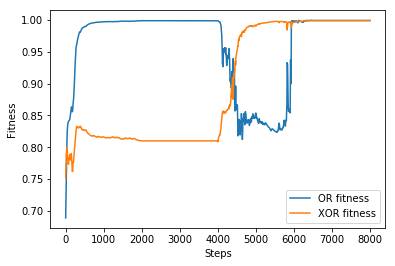

------------
Initial Capacity:  1
Added Capacity:  1
OR probability:  1.0


HBox(children=(IntProgress(value=0), HTML(value='')))


Epochs average: 3193.0
OR Loss average: tensor(0.5986, grad_fn=<DivBackward0>)
XOR Loss average: tensor(0.9990, grad_fn=<DivBackward0>)
OR Loss average after decrease: tensor(0.9996, grad_fn=<DivBackward0>)
XOR Loss average after decrease: tensor(0.8070, grad_fn=<DivBackward0>)
OR Loss average after decrease initial: tensor(0.5244, grad_fn=<DivBackward0>)
XOR Loss average after decrease initial: tensor(0.8066, grad_fn=<DivBackward0>)
OR Loss average after decrease where it matters: tensor(0.9995, grad_fn=<DivBackward0>)
XOR Loss average after decrease where it matters: tensor(0.5114, grad_fn=<DivBackward0>)
OR Loss average after decrease initial where it matters: tensor(0.5109, grad_fn=<DivBackward0>)
XOR Loss average after decrease initial where it matters: tensor(0.9986, grad_fn=<DivBackward0>)
Average Loss: tensor(0.7988, grad_fn=<DivBackward0>)
Standard Deviation Fitness: 0.2001786231994629
Fitness : tensor(0.5986, grad_fn=<SubBackward0>)
Percentage reach threshold:  0
Common Weig

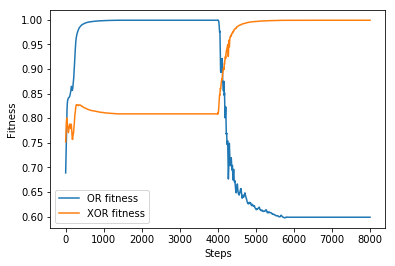

------------
Initial Capacity:  1
Added Capacity:  1
OR probability:  0.5


HBox(children=(IntProgress(value=0), HTML(value='')))


Epochs average: 6208.0
OR Loss average: tensor(0.9998, grad_fn=<DivBackward0>)
XOR Loss average: tensor(0.9990, grad_fn=<DivBackward0>)
OR Loss average after decrease: tensor(0.5819, grad_fn=<DivBackward0>)
XOR Loss average after decrease: tensor(0.6761, grad_fn=<DivBackward0>)
OR Loss average after decrease initial: tensor(0.8000, grad_fn=<DivBackward0>)
XOR Loss average after decrease initial: tensor(0.7996, grad_fn=<DivBackward0>)
OR Loss average after decrease where it matters: tensor(0.5107, grad_fn=<DivBackward0>)
XOR Loss average after decrease where it matters: tensor(0.9995, grad_fn=<DivBackward0>)
OR Loss average after decrease initial where it matters: tensor(0.9994, grad_fn=<DivBackward0>)
XOR Loss average after decrease initial where it matters: tensor(0.9975, grad_fn=<DivBackward0>)
Average Loss: tensor(0.9994, grad_fn=<DivBackward0>)
Standard Deviation Fitness: 0.00041954040527347747
Fitness : tensor(0.9990, grad_fn=<SubBackward0>)
Percentage reach threshold:  100
Commo

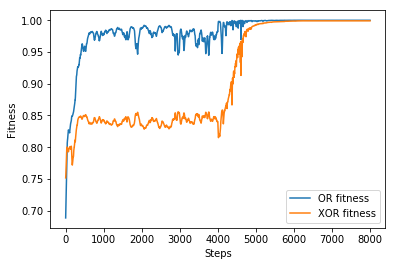

------------
Initial Capacity:  2
Added Capacity:  1
OR probability:  0.9


HBox(children=(IntProgress(value=0), HTML(value='')))


Epochs average: 4697.0
OR Loss average: tensor(0.9987, grad_fn=<DivBackward0>)
XOR Loss average: tensor(0.9990, grad_fn=<DivBackward0>)
OR Loss average after decrease: tensor(0.9997, grad_fn=<DivBackward0>)
XOR Loss average after decrease: tensor(0.8034, grad_fn=<DivBackward0>)
OR Loss average after decrease initial: tensor(0.5800, grad_fn=<DivBackward0>)
XOR Loss average after decrease initial: tensor(0.6707, grad_fn=<DivBackward0>)
OR Loss average after decrease where it matters: tensor(0.9999, grad_fn=<DivBackward0>)
XOR Loss average after decrease where it matters: tensor(0.5056, grad_fn=<DivBackward0>)
OR Loss average after decrease initial where it matters: tensor(0.5021, grad_fn=<DivBackward0>)
XOR Loss average after decrease initial where it matters: tensor(1., grad_fn=<DivBackward0>)
Average Loss: tensor(0.9988, grad_fn=<DivBackward0>)
Standard Deviation Fitness: 0.00015739440917966752
Fitness : tensor(0.9987, grad_fn=<SubBackward0>)
Percentage reach threshold:  0
Common Weig

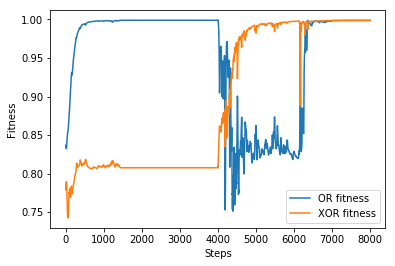

------------
Initial Capacity:  2
Added Capacity:  1
OR probability:  1.0


HBox(children=(IntProgress(value=0), HTML(value='')))


Epochs average: 3110.0
OR Loss average: tensor(0.6157, grad_fn=<DivBackward0>)
XOR Loss average: tensor(0.9990, grad_fn=<DivBackward0>)
OR Loss average after decrease: tensor(0.9995, grad_fn=<DivBackward0>)
XOR Loss average after decrease: tensor(0.8061, grad_fn=<DivBackward0>)
OR Loss average after decrease initial: tensor(0.5714, grad_fn=<DivBackward0>)
XOR Loss average after decrease initial: tensor(0.6742, grad_fn=<DivBackward0>)
OR Loss average after decrease where it matters: tensor(0.9996, grad_fn=<DivBackward0>)
XOR Loss average after decrease where it matters: tensor(0.5101, grad_fn=<DivBackward0>)
OR Loss average after decrease initial where it matters: tensor(0.5000, grad_fn=<DivBackward0>)
XOR Loss average after decrease initial where it matters: tensor(1., grad_fn=<DivBackward0>)
Average Loss: tensor(0.8074, grad_fn=<DivBackward0>)
Standard Deviation Fitness: 0.19164840698242191
Fitness : tensor(0.6157, grad_fn=<SubBackward0>)
Percentage reach threshold:  0
Common Weight 

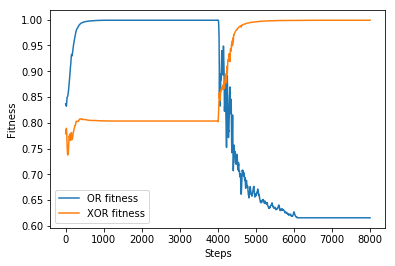

------------
Initial Capacity:  2
Added Capacity:  1
OR probability:  0.5


HBox(children=(IntProgress(value=0), HTML(value='')))


Epochs average: 2259.0
OR Loss average: tensor(0.9997, grad_fn=<DivBackward0>)
XOR Loss average: tensor(0.9990, grad_fn=<DivBackward0>)
OR Loss average after decrease: tensor(0.9999, grad_fn=<DivBackward0>)
XOR Loss average after decrease: tensor(0.9951, grad_fn=<DivBackward0>)
OR Loss average after decrease initial: tensor(0.5829, grad_fn=<DivBackward0>)
XOR Loss average after decrease initial: tensor(0.6767, grad_fn=<DivBackward0>)
OR Loss average after decrease where it matters: tensor(0.9999, grad_fn=<DivBackward0>)
XOR Loss average after decrease where it matters: tensor(0.9811, grad_fn=<DivBackward0>)
OR Loss average after decrease initial where it matters: tensor(0.5105, grad_fn=<DivBackward0>)
XOR Loss average after decrease initial where it matters: tensor(0.9996, grad_fn=<DivBackward0>)
Average Loss: tensor(0.9994, grad_fn=<DivBackward0>)
Standard Deviation Fitness: 0.0003566741943359375
Fitness : tensor(0.9990, grad_fn=<SubBackward0>)
Percentage reach threshold:  100
Common

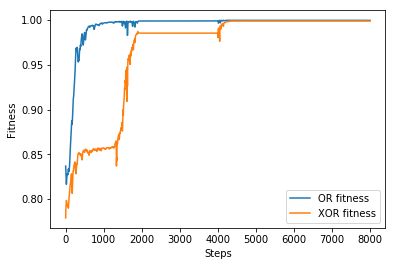

------------
Initial Capacity:  1
Added Capacity:  2
OR probability:  0.9


HBox(children=(IntProgress(value=0), HTML(value='')))


Epochs average: 3410.0
OR Loss average: tensor(0.9840, grad_fn=<DivBackward0>)
XOR Loss average: tensor(0.9990, grad_fn=<DivBackward0>)
OR Loss average after decrease: tensor(0.9559, grad_fn=<DivBackward0>)
XOR Loss average after decrease: tensor(0.8531, grad_fn=<DivBackward0>)
OR Loss average after decrease initial: tensor(0.7898, grad_fn=<DivBackward0>)
XOR Loss average after decrease initial: tensor(0.7996, grad_fn=<DivBackward0>)
OR Loss average after decrease where it matters: tensor(0.9421, grad_fn=<DivBackward0>)
XOR Loss average after decrease where it matters: tensor(0.6387, grad_fn=<DivBackward0>)
OR Loss average after decrease initial where it matters: tensor(0.9390, grad_fn=<DivBackward0>)
XOR Loss average after decrease initial where it matters: tensor(0.9979, grad_fn=<DivBackward0>)
Average Loss: tensor(0.9915, grad_fn=<DivBackward0>)
Standard Deviation Fitness: 0.00749614715576169
Fitness : tensor(0.9840, grad_fn=<SubBackward0>)
Percentage reach threshold:  0
Common Wei

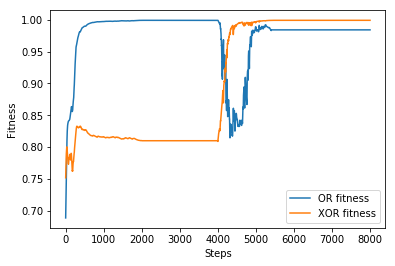

------------
Initial Capacity:  1
Added Capacity:  2
OR probability:  1.0


HBox(children=(IntProgress(value=0), HTML(value='')))


Epochs average: 2802.0
OR Loss average: tensor(0.6002, grad_fn=<DivBackward0>)
XOR Loss average: tensor(0.9990, grad_fn=<DivBackward0>)
OR Loss average after decrease: tensor(0.9998, grad_fn=<DivBackward0>)
XOR Loss average after decrease: tensor(0.8055, grad_fn=<DivBackward0>)
OR Loss average after decrease initial: tensor(0.5254, grad_fn=<DivBackward0>)
XOR Loss average after decrease initial: tensor(0.8051, grad_fn=<DivBackward0>)
OR Loss average after decrease where it matters: tensor(0.9997, grad_fn=<DivBackward0>)
XOR Loss average after decrease where it matters: tensor(0.5089, grad_fn=<DivBackward0>)
OR Loss average after decrease initial where it matters: tensor(0.5061, grad_fn=<DivBackward0>)
XOR Loss average after decrease initial where it matters: tensor(0.9988, grad_fn=<DivBackward0>)
Average Loss: tensor(0.7996, grad_fn=<DivBackward0>)
Standard Deviation Fitness: 0.19939804077148438
Fitness : tensor(0.6002, grad_fn=<SubBackward0>)
Percentage reach threshold:  0
Common Wei

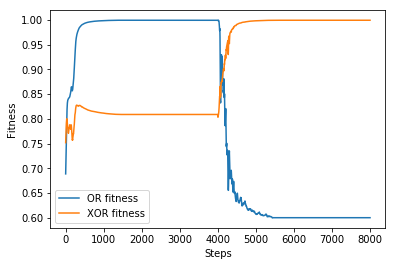

------------
Initial Capacity:  1
Added Capacity:  2
OR probability:  0.5


HBox(children=(IntProgress(value=0), HTML(value='')))


Epochs average: 5950.0
OR Loss average: tensor(0.9999, grad_fn=<DivBackward0>)
XOR Loss average: tensor(0.9990, grad_fn=<DivBackward0>)
OR Loss average after decrease: tensor(0.5841, grad_fn=<DivBackward0>)
XOR Loss average after decrease: tensor(0.6780, grad_fn=<DivBackward0>)
OR Loss average after decrease initial: tensor(0.7999, grad_fn=<DivBackward0>)
XOR Loss average after decrease initial: tensor(0.7994, grad_fn=<DivBackward0>)
OR Loss average after decrease where it matters: tensor(0.5130, grad_fn=<DivBackward0>)
XOR Loss average after decrease where it matters: tensor(0.9993, grad_fn=<DivBackward0>)
OR Loss average after decrease initial where it matters: tensor(0.9994, grad_fn=<DivBackward0>)
XOR Loss average after decrease initial where it matters: tensor(0.9971, grad_fn=<DivBackward0>)
Average Loss: tensor(0.9994, grad_fn=<DivBackward0>)
Standard Deviation Fitness: 0.0004283905029296986
Fitness : tensor(0.9990, grad_fn=<SubBackward0>)
Percentage reach threshold:  100
Common

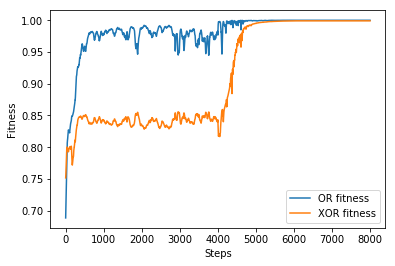

In [8]:
def train_both(iters, p, mode, delta, net, optim):
    criterion = nn.MSELoss()
    OR_losses = []
    XOR_losses = []
    average_losses = []
    
    steps = 0
    for epoch in range(iters):
        r = np.random.choice([0,1,2,3], 1)
        if np.random.rand()<p:
            for X, Y in zip(Xs_OR[r], Ys_OR[r]):
                steps+=1
                optim.zero_grad()
                output = net(X.view(1,-1) + torch.FloatTensor(X.view(1,-1).size()).uniform_(-delta,delta))
                loss = criterion(output,Y.view(1,-1))
                
                loss.backward()
                optim.step()
                with torch.no_grad():
                    OR_loss = 1.0 / (1.0+criterion(net(Xs_OR),Ys_OR))
                    XOR_loss = 1.0 / (1.0+criterion(net(Xs_XOR),Ys_XOR))
                    average_loss = (OR_loss + XOR_loss)/2
                    
                    OR_losses.append(OR_loss)
                    XOR_losses.append(XOR_loss)
                    average_losses.append(average_loss)
                    
                    if mode==0:
                        if OR_loss > 1.0 - 0.001:
                            
                            return steps, OR_losses, XOR_losses, average_losses, net,optim
                    else:
                        if XOR_loss > 1.0 - 0.001:
                            
                            return steps, OR_losses, XOR_losses, average_losses, net,optim
        else:
            for X, Y in zip(Xs_XOR[r], Ys_XOR[r]):
                steps+=1
                optim.zero_grad()
                output = net(X.view(1,-1) + torch.FloatTensor(X.view(1,-1).size()).uniform_(-delta,delta))
                loss = criterion(output,Y.view(1,-1))
                
                loss.backward()
                optim.step()
                with torch.no_grad():
                    OR_loss = 1.0 / (1.0+criterion(net(Xs_OR),Ys_OR))
                    XOR_loss = 1.0 / (1.0+criterion(net(Xs_XOR),Ys_XOR))
                    average_loss = (OR_loss + XOR_loss)/2
                    
                    OR_losses.append(OR_loss)
                    XOR_losses.append(XOR_loss)
                    average_losses.append(average_loss)
                    
                    if mode==0:
                        if OR_loss > 1.0 - 0.001:
                            
                            return steps, OR_losses, XOR_losses, average_losses, net,optim
                    else:
                        if XOR_loss > 1.0 - 0.001:
                            
                            return steps, OR_losses, XOR_losses, average_losses, net,optim
                        
    return steps, OR_losses, XOR_losses, average_losses, net,optim

def experiment(initial_capacity, added_capacity, OR_p):
    print('------------')
    print('Initial Capacity: ', initial_capacity)
    print('Added Capacity: ', added_capacity)
    print('OR probability: ', OR_p)
    seeds = 100

    steps = 0
    
    OR_loss = 0.0
    XOR_loss = 0.0
    
    OR_loss_after_decrease = 0.0
    XOR_loss_after_decrease = 0.0
    
    XOR_loss_after_decrease_wim = 0.0
    OR_loss_after_decrease_wim = 0.0
    
    XOR_loss_after_decrease_initial = 0.0
    OR_loss_after_decrease_initial = 0.0
    
    XOR_loss_after_decrease_initial_wim = 0.0
    OR_loss_after_decrease_initial_wim = 0.0
    
    plot_OR = np.zeros(8000)
    plot_XOR = np.zeros(8000)

    average_reach_threshold = 0
    
    common_weight_change_l0 = 0.0
    common_bias_change_l0 = 0.0
    common_weight_change_l1 = 0.0
    common_bias_change_l1 = 0.0
    new_weight_change_l0 = 0.0
    new_bias_change_l0 = 0.0
    new_weight_change_l1 = 0.0
    
    best_fitness = 0.0
    best_net = None

    for seed in tqdm_notebook(range(seeds)):
        np.random.seed(43)
        torch.manual_seed(43)
        net = network(3,initial_capacity, torch.nn.functional.sigmoid)
        optim = torch.optim.Adam(net.parameters(), lr=0.05)
        criterion = nn.MSELoss()

        step, OR_losses, XOR_losses, average_losses, net, optim = train_both(4000, OR_p, 0, 0.0, net, optim)
        plot_OR[:step] += np.array(OR_losses)
        plot_OR[step: 4000] += np.array([OR_losses[-1]]*(4000-step))
        plot_XOR[:step] += np.array(XOR_losses)
        plot_XOR[step: 4000] += np.array([XOR_losses[-1]]*(4000-step))

        steps += step
        net_before_increase = copy.deepcopy(net)
        net, optim = increase_capacity_keep_lr(net, added_capacity, optim, 'cpu', 0.05)
        optim = torch.optim.Adam(net.parameters(), lr=0.05)
        net_after_increase = copy.deepcopy(net)
        step, OR_losses, XOR_losses, average_losses, net, optim = train_both(4000, 1.0-OR_p, 1, 0.0, net, optim)
        plot_OR[4000: step + 4000] += np.array(OR_losses)
        plot_OR[step + 4000:] += np.array([OR_losses[-1]]*(4000-step))
        plot_XOR[4000: step + 4000] += np.array(XOR_losses)
        plot_XOR[step + 4000:] += np.array([XOR_losses[-1]]*(4000-step))

        steps += step

        OR_loss += 1.0 / (1.0+criterion(net(Xs_OR),Ys_OR))
        XOR_loss += 1.0 / (1.0+criterion(net(Xs_XOR),Ys_XOR))
        
        if ((1.0 / (1.0+criterion(net(Xs_OR),Ys_OR))) + (1.0 / (1.0+criterion(net(Xs_XOR),Ys_XOR))))/2 > 0.999:
            average_reach_threshold += 1
        
        if ((1.0 / (1.0+criterion(net(Xs_OR),Ys_OR))) + (1.0 / (1.0+criterion(net(Xs_XOR),Ys_XOR))))/2 > best_fitness:
            best_fitness = ((1.0 / (1.0+criterion(net(Xs_OR),Ys_OR))) + (1.0 / (1.0+criterion(net(Xs_XOR),Ys_XOR))))/2
            best_net = (net_before_increase, net_after_increase, net)
        

        common_weight_change_l0 += torch.mean(torch.abs(net.fc1.weight.data[:-added_capacity] - net_after_increase.fc1.weight.data[:-added_capacity])).item()
        common_bias_change_l0 += torch.mean(torch.abs(net.fc1.bias.data[:-added_capacity] - net_after_increase.fc1.bias.data[:-added_capacity])).item()
        
        common_weight_change_l1 += torch.mean(torch.abs(net.fc2.weight.data[:,:-added_capacity] - net_after_increase.fc2.weight.data[:,:-added_capacity])).item()
        common_bias_change_l1 += torch.mean(torch.abs(net.fc2.bias.data - net_after_increase.fc2.bias.data)).item()
        
        new_weight_change_l0 += torch.mean(torch.abs(net.fc1.weight.data[-added_capacity:] - net_after_increase.fc1.weight.data[-added_capacity:])).item()
        new_bias_change_l0 += torch.mean(torch.abs(net.fc1.bias.data[-added_capacity:] - net_after_increase.fc1.bias.data[-added_capacity:])).item()
        
        new_weight_change_l1 += torch.mean(torch.abs(net.fc2.weight.data[:,-added_capacity:] - net_after_increase.fc2.weight.data[:,-added_capacity:])).item()

# 

        net_decrease = copy.deepcopy(net)
        net_decrease.decrease_capacity(added_capacity)
        OR_loss_after_decrease += 1.0 / (1.0 + criterion(net_decrease(Xs_OR),Ys_OR))
        XOR_loss_after_decrease += 1.0 / (1.0 + criterion(net_decrease(Xs_XOR),Ys_XOR))
        
        OR_loss_after_decrease_wim += 1.0 / (1.0 + criterion(net_decrease(Xs_OR[-1]),Ys_OR[-1]))
        XOR_loss_after_decrease_wim += 1.0 / (1.0 + criterion(net_decrease(Xs_XOR[-1]),Ys_XOR[-1]))
        
        net_decrease_initial = copy.deepcopy(net)
        net_decrease_initial.decrease_capacity_initial(initial_capacity)
        OR_loss_after_decrease_initial += 1.0 / (1.0 + criterion(net_decrease_initial(Xs_OR),Ys_OR))
        XOR_loss_after_decrease_initial += 1.0 / (1.0 + criterion(net_decrease_initial(Xs_XOR),Ys_XOR))
        
        OR_loss_after_decrease_initial_wim += 1.0 / (1.0 + criterion(net_decrease_initial(Xs_OR[-1]),Ys_OR[-1]))
        XOR_loss_after_decrease_initial_wim += 1.0 / (1.0 + criterion(net_decrease_initial(Xs_XOR[-1]),Ys_XOR[-1]))

    print('Epochs average:', steps/seeds)
    print('OR Loss average:', OR_loss/seeds)
    print('XOR Loss average:', XOR_loss/seeds)
    print('OR Loss average after decrease:', OR_loss_after_decrease/seeds)
    print('XOR Loss average after decrease:', XOR_loss_after_decrease/seeds)
    print('OR Loss average after decrease initial:', OR_loss_after_decrease_initial/seeds)
    print('XOR Loss average after decrease initial:', XOR_loss_after_decrease_initial/seeds)
    
    print('OR Loss average after decrease where it matters:', OR_loss_after_decrease_wim/seeds)
    print('XOR Loss average after decrease where it matters:', XOR_loss_after_decrease_wim/seeds)
    print('OR Loss average after decrease initial where it matters:', OR_loss_after_decrease_initial_wim/seeds)
    print('XOR Loss average after decrease initial where it matters:', XOR_loss_after_decrease_initial_wim/seeds)
    
    print('Average Loss:', (XOR_loss+OR_loss)/(2*seeds))
    print('Standard Deviation Fitness:', np.std([OR_loss.item()/seeds, XOR_loss.item()/seeds]))
    print('Fitness :', (XOR_loss+OR_loss)/(2*seeds) - np.std([OR_loss.item()/seeds, XOR_loss.item()/seeds]))
    print('Percentage reach threshold: ', average_reach_threshold)
    print('Common Weight change fc1: ', common_weight_change_l0/seeds)
    print('Common Bias change fc1: ', common_bias_change_l0/seeds)
    print('Common Weight change fc2: ', common_weight_change_l1/seeds)
    print('Common Bias change fc2: ', common_bias_change_l1/seeds)
    print('new Weight change fc1: ', new_weight_change_l0/seeds)
    print('new Bias change fc1: ', new_bias_change_l0/seeds)
    print('new Weight change fc2: ', new_weight_change_l1/seeds)

    plt.plot([i for i in range(8000)],plot_OR / float(seeds))
    plt.plot([i for i in range(8000)],plot_XOR / float(seeds))
    plt.legend(['OR fitness', 'XOR fitness'])
    plt.xlabel('Steps')
    plt.ylabel('Fitness')
    plt.show()
    return best_net
    
before_increase, net_after_increase, net = experiment(1,1,0.9)
before_increase, net_after_increase, net = experiment(1,1,1.0)
before_increase, net_after_increase, net = experiment(1,1,0.5)
before_increase, net_after_increase, net = experiment(2,1,0.9)
before_increase, net_after_increase, net = experiment(2,1,1.0)
before_increase, net_after_increase, net = experiment(2,1,0.5)
before_increase, net_after_increase, net = experiment(1,2,0.9)
before_increase, net_after_increase, net = experiment(1,2,1.0)
before_increase, net_after_increase, net = experiment(1,2,0.5)

# Hirose Increasing Only

------------
OR probability:  0.9
Neuron limit:  99999


HBox(children=(IntProgress(value=0), HTML(value='')))


Epochs average: 2995.19
Hidden average: 5.12
OR Loss average: tensor(0.9684, grad_fn=<DivBackward0>)
XOR Loss average: tensor(0.9990, grad_fn=<DivBackward0>)
Average Loss: tensor(0.9837, grad_fn=<DivBackward0>)
Fitness:  0.968390121459961


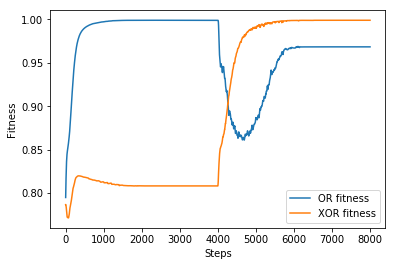

------------
OR probability:  1.0
Neuron limit:  99999


HBox(children=(IntProgress(value=0), HTML(value='')))


Epochs average: 3887.83
Hidden average: 2.75
OR Loss average: tensor(0.6142, grad_fn=<DivBackward0>)
XOR Loss average: tensor(0.9990, grad_fn=<DivBackward0>)
Average Loss: tensor(0.8066, grad_fn=<DivBackward0>)
Fitness:  0.6141553115844727


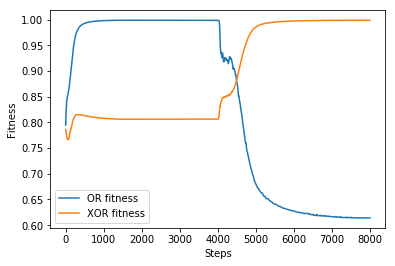

------------
OR probability:  0.5
Neuron limit:  99999


HBox(children=(IntProgress(value=0), HTML(value='')))


Epochs average: 2422.94
Hidden average: 6.3
OR Loss average: tensor(0.9998, grad_fn=<DivBackward0>)
XOR Loss average: tensor(0.9990, grad_fn=<DivBackward0>)
Average Loss: tensor(0.9994, grad_fn=<DivBackward0>)
Fitness:  0.9990154266357423


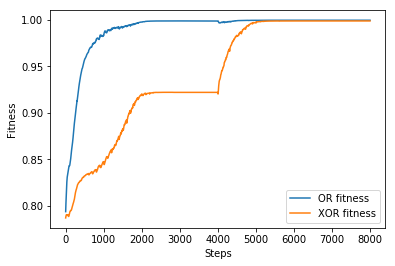

------------
OR probability:  0.9
Neuron limit:  2


HBox(children=(IntProgress(value=0), HTML(value='')))


Epochs average: 4280.34
Hidden average: 2.0
OR Loss average: tensor(0.9966, grad_fn=<DivBackward0>)
XOR Loss average: tensor(0.9939, grad_fn=<DivBackward0>)
Average Loss: tensor(0.9953, grad_fn=<DivBackward0>)
Fitness:  0.993924560546875


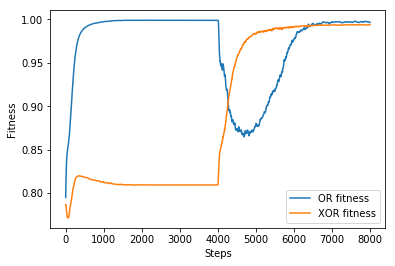

------------
OR probability:  1.0
Neuron limit:  2


HBox(children=(IntProgress(value=0), HTML(value='')))


Epochs average: 4261.62
Hidden average: 2.0
OR Loss average: tensor(0.6085, grad_fn=<DivBackward0>)
XOR Loss average: tensor(0.9990, grad_fn=<DivBackward0>)
Average Loss: tensor(0.8038, grad_fn=<DivBackward0>)
Fitness:  0.6085490798950195


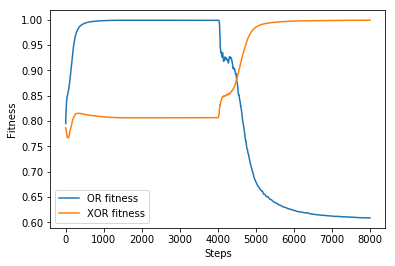

------------
OR probability:  0.5
Neuron limit:  2


HBox(children=(IntProgress(value=0), HTML(value='')))


Epochs average: 4837.97
Hidden average: 2.0
OR Loss average: tensor(0.9990, grad_fn=<DivBackward0>)
XOR Loss average: tensor(0.9535, grad_fn=<DivBackward0>)
Average Loss: tensor(0.9762, grad_fn=<DivBackward0>)
Fitness:  0.9534876251220703


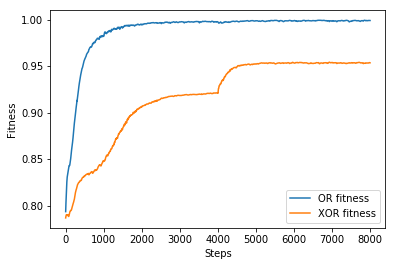

------------
OR probability:  0.9
Neuron limit:  3


HBox(children=(IntProgress(value=0), HTML(value='')))


Epochs average: 3599.2
Hidden average: 3.0
OR Loss average: tensor(0.9857, grad_fn=<DivBackward0>)
XOR Loss average: tensor(0.9990, grad_fn=<DivBackward0>)
Average Loss: tensor(0.9924, grad_fn=<DivBackward0>)
Fitness:  0.9857077026367187


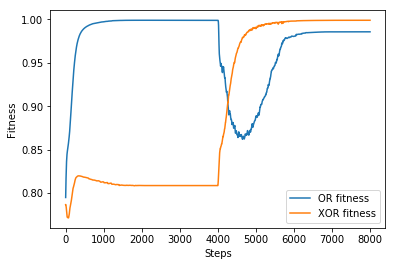

------------
OR probability:  1.0
Neuron limit:  3


HBox(children=(IntProgress(value=0), HTML(value='')))


Epochs average: 3908.22
Hidden average: 2.69
OR Loss average: tensor(0.6142, grad_fn=<DivBackward0>)
XOR Loss average: tensor(0.9990, grad_fn=<DivBackward0>)
Average Loss: tensor(0.8066, grad_fn=<DivBackward0>)
Fitness:  0.6141611099243163


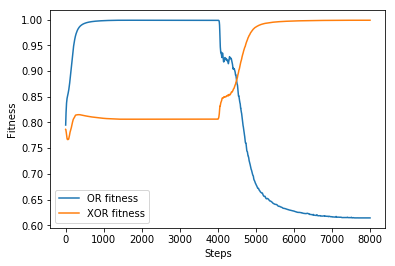

------------
OR probability:  0.5
Neuron limit:  3


HBox(children=(IntProgress(value=0), HTML(value='')))


Epochs average: 3646.35
Hidden average: 3.0
OR Loss average: tensor(0.9997, grad_fn=<DivBackward0>)
XOR Loss average: tensor(0.9979, grad_fn=<DivBackward0>)
Average Loss: tensor(0.9988, grad_fn=<DivBackward0>)
Fitness:  0.9978816986083985


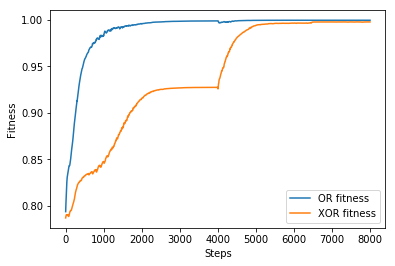

In [9]:
def train_both(iters, p, mode, delta, net, optim, limit):
    OR_losses = []
    XOR_losses = []
    average_losses = []
    
    steps = 0
    previous_loss = 0.0
    for epoch in range(iters):
        r = np.random.choice([0,1,2,3], 1)
        if np.random.rand()<p:
            for X, Y in zip(Xs_OR[r], Ys_OR[r]):
                steps+=1
                optim.zero_grad()
                output = net(X.view(1,-1) + torch.FloatTensor(X.view(1,-1).size()).uniform_(-delta,delta))
                loss = criterion(output,Y.view(1,-1))
                
                loss.backward()
                optim.step()
                with torch.no_grad():
                    OR_loss = 1.0 / (1.0+criterion(net(Xs_OR),Ys_OR))
                    XOR_loss = 1.0 / (1.0+criterion(net(Xs_XOR),Ys_XOR))
                    average_loss = (OR_loss + XOR_loss)/2
                    
                    OR_losses.append(OR_loss)
                    XOR_losses.append(XOR_loss)
                    average_losses.append(average_loss)
                    
                    if mode==0:
                        if OR_loss > 1.0 - 0.001:
                            
                            return steps, OR_losses, XOR_losses, average_losses, net, optim
                        
                        if steps % 100 == 0 and steps>0:
                            if OR_loss < 1.0001 * previous_loss and net.fc1.out_features < limit:
                                net.increase_capacity(1)
                                optim = torch.optim.Adam(net.parameters(),lr=0.05)
                            previous_loss = OR_loss
                    else:
                        if XOR_loss > 1.0 - 0.001:
                            
                            return steps, OR_losses, XOR_losses, average_losses, net, optim
                        
                        if steps % 100 == 0 and steps>0:
                            if XOR_loss < 1.001 * previous_loss and net.fc1.out_features < limit:
                                net.increase_capacity(1)
                                optim = torch.optim.Adam(net.parameters(),lr=0.05)
                            previous_loss = XOR_loss
        else:
            for X, Y in zip(Xs_XOR[r], Ys_XOR[r]):
                steps+=1
                optim.zero_grad()
                output = net(X.view(1,-1) + torch.FloatTensor(X.view(1,-1).size()).uniform_(-delta,delta))
                loss = criterion(output,Y.view(1,-1))
                
                loss.backward()
                optim.step()
                with torch.no_grad():
                    OR_loss = 1.0 / (1.0+criterion(net(Xs_OR),Ys_OR))
                    XOR_loss = 1.0 / (1.0+criterion(net(Xs_XOR),Ys_XOR))
                    average_loss = (OR_loss + XOR_loss)/2
                    
                    OR_losses.append(OR_loss)
                    XOR_losses.append(XOR_loss)
                    average_losses.append(average_loss)
                    
                    if mode==0:
                        if OR_loss > 1.0 - 0.001:
                            
                            return steps, OR_losses, XOR_losses, average_losses, net, optim
                        
                        if steps % 100 == 0 and steps>0:
                            if OR_loss < 1.0001 * previous_loss and net.fc1.out_features < limit:
                                net.increase_capacity(1)
                                optim = torch.optim.Adam(net.parameters(),lr=0.05)
                            previous_loss = OR_loss
                    else:
                        if XOR_loss > 1.0 - 0.001:
                            
                            return steps, OR_losses, XOR_losses, average_losses, net, optim
                        
                        if steps % 100 == 0 and steps>0:
                            if XOR_loss < 1.0001 * previous_loss and net.fc1.out_features < limit:
                                net.increase_capacity(1)
                                optim = torch.optim.Adam(net.parameters(),lr=0.05)
                            previous_loss = XOR_loss
                        
    return steps, OR_losses, XOR_losses, average_losses, net, optim

def experiment(OR_p, limit):
    print('------------')
    print('OR probability: ', OR_p)
    print('Neuron limit: ', limit)
    seeds = 100

    steps = 0
    hidden_layer = 0
    XOR_loss = 0.0
    OR_loss = 0.0
    plot_OR = np.zeros(8000)
    plot_XOR = np.zeros(8000)

    for seed in tqdm_notebook(range(seeds)):
        np.random.seed(seed)
        torch.manual_seed(seed)
        net = network(3,1, torch.sigmoid)
        optim = torch.optim.Adam(net.parameters(), lr=0.05)
        criterion = nn.MSELoss()

        step, OR_losses, XOR_losses, average_losses, net, optim = train_both(4000, OR_p, 0, 0.0, net, optim, limit)
        plot_OR[:step] += np.array(OR_losses)
        plot_OR[step: 4000] += np.array([OR_losses[-1]]*(4000-step))
        plot_XOR[:step] += np.array(XOR_losses)
        plot_XOR[step: 4000] += np.array([XOR_losses[-1]]*(4000-step))

        steps += step + 1
        step, OR_losses, XOR_losses, average_losses, net, optim = train_both(4000, 1-OR_p, 1, 0.0, net, optim, limit)
        plot_OR[4000: step + 4000] += np.array(OR_losses)
        plot_OR[step + 4000:] += np.array([OR_losses[-1]]*(4000-step))
        plot_XOR[4000: step + 4000] += np.array(XOR_losses)
        plot_XOR[step + 4000:] += np.array([XOR_losses[-1]]*(4000-step))

        steps += step + 1

        hidden_layer += net.fc1.out_features

        OR_loss += 1.0 / (1.0+criterion(net(Xs_OR),Ys_OR))
        XOR_loss += 1.0 / (1.0+criterion(net(Xs_XOR),Ys_XOR))

    print('Epochs average:', steps/seeds)
    print('Hidden average:', hidden_layer/seeds)
    print('OR Loss average:', OR_loss/seeds)
    print('XOR Loss average:', XOR_loss/seeds)
    print('Average Loss:', (XOR_loss+OR_loss)/(2*seeds))
    print('Fitness: ', np.mean([OR_loss.item()/seeds, XOR_loss.item()/seeds]) - np.std([OR_loss.item()/seeds, XOR_loss.item()/seeds]))
    plt.plot([i for i in range(8000)],plot_OR / float(seeds))
    plt.plot([i for i in range(8000)],plot_XOR / float(seeds))
    plt.legend(['OR fitness', 'XOR fitness'])
    plt.xlabel('Steps')
    plt.ylabel('Fitness')
    plt.show()
    
experiment(0.9, 99999)
experiment(1.0, 99999)
experiment(0.5, 99999)
experiment(0.9, 2)
experiment(1.0, 2)
experiment(0.5, 2)
experiment(0.9, 3)
experiment(1.0, 3)
experiment(0.5, 3)

# EXP3S Experiments

In [10]:
# Scales rewards. Have emailed about how to implement for when there is no history or an history of 1 reward. 
# No answer as of yet, but my guess is that returning 0 will not affect the probabilites
def scale_reward(unscaled_reward, history_unscaled_rewards):
    if not history_unscaled_rewards:
        return 0

    q_lo = np.quantile(history_unscaled_rewards, 0.2)
    q_hi = np.quantile(history_unscaled_rewards, 0.8)
    
    if unscaled_reward < q_lo:
        return -1
    
    if unscaled_reward > q_hi:
        return 1
    
    if q_lo == q_hi:
        return 0
    
    return (2*(unscaled_reward - q_lo)/(q_hi-q_lo)) - 1

In [11]:
class EXP3S(object):
    def __init__(self, N_arms, eta, beta, epsilon):
        self.N_arms = N_arms
        
        self.eta = eta
        self.beta = beta
        self.epsilon = epsilon
        
        self.weights = np.zeros((2,self.N_arms))
        
        self.t = 0
        self.alpha = None
        
    def exp3(self, arm):
        return np.exp(self.weights[0][arm])/np.sum(np.exp(self.weights[0]))
        
    def sample_probability(self, arm):
        return (1-self.epsilon)*self.exp3(arm) + self.epsilon/self.N_arms
    
    def sample_probabilities(self):
        sample_probabilities = []
        for arm in range(self.N_arms):
            sample_probabilities.append(self.sample_probability(arm))
        return sample_probabilities
    
    def importance_sampling_reward(self, reward, previous_action):
        #2.2.1
        importance_sampled_rewards = []
        for i in range(self.N_arms):
            numerator = self.beta
            if previous_action==i:
                numerator += reward
            importance_sampled_rewards.append(numerator/self.sample_probability(i))

        return importance_sampled_rewards
        
    def update_weights(self, reward, previous_action):
        old_weights = copy.deepcopy(self.weights[0])
        
        self.t += 1
        alpha = 1/self.t
        
        importance_sampled_rewards = self.importance_sampling_reward(reward, previous_action)
        
        for i in range(self.N_arms):
            self.weights[0][i] = np.log((1-alpha)*np.exp(self.weights[1][i]
                                        + self.eta*importance_sampled_rewards[i]) 
                                        + (alpha/(self.N_arms - 1)*np.sum([np.exp(self.weights[1][j] 
                                        + self.eta*importance_sampled_rewards[j]) if j!=i else 0 for j in range(self.N_arms)])))
        
        self.weights[1] = old_weights

# Graves
Two tasks

In [12]:
# Settings from Graves et al.



N = 2
eta = 10e-3
beta = 0
epsilon = 0.05
max_history_length = 100

tasks = [[(torch.tensor([0,0,0],dtype=torch.float), torch.tensor([0], dtype=torch.float)),
          (torch.tensor([0,1,0],dtype=torch.float), torch.tensor([1], dtype=torch.float)),
          (torch.tensor([1,0,0],dtype=torch.float), torch.tensor([1], dtype=torch.float)),
          (torch.tensor([1,1,0],dtype=torch.float), torch.tensor([1], dtype=torch.float))],
         [(torch.tensor([0,0,1],dtype=torch.float), torch.tensor([0], dtype=torch.float)),
          (torch.tensor([0,1,1],dtype=torch.float), torch.tensor([1], dtype=torch.float)),
          (torch.tensor([1,0,1],dtype=torch.float), torch.tensor([1], dtype=torch.float)),
          (torch.tensor([1,1,1],dtype=torch.float), torch.tensor([0], dtype=torch.float))]]

Initial Capacity:  1
Fixed Architecture:  False
Limit:  1


HBox(children=(IntProgress(value=0), HTML(value='')))

/home/joe/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/joe/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Average number of hidden neurons 1.0
Average number of steps 7999.0
Average OR Loss:  0.9398309260606765
Average XOR Loss:  0.8444446700811387
Mean loss:  0.8921377980709075
Std loss:  0.047693127989768935
Fitness : 0.8444446700811385


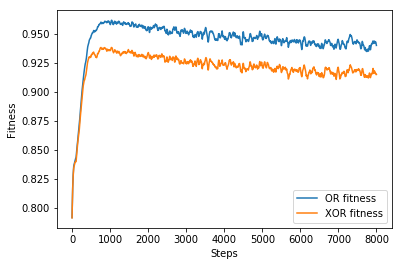

Initial Capacity:  2
Fixed Architecture:  False
Limit:  2


HBox(children=(IntProgress(value=0), HTML(value='')))


Average number of hidden neurons 2.0
Average number of steps 7999.0
Average OR Loss:  0.9602251690626145
Average XOR Loss:  0.8649131470918655
Mean loss:  0.9125691580772399
Std loss:  0.047656010985374475
Fitness : 0.8649131470918654


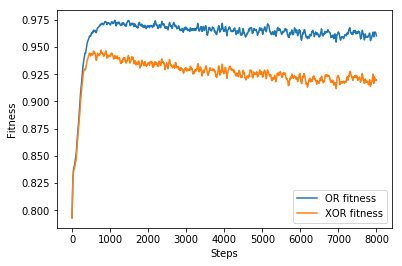

Initial Capacity:  3
Fixed Architecture:  False
Limit:  3


HBox(children=(IntProgress(value=0), HTML(value='')))


Average number of hidden neurons 3.0
Average number of steps 7955.88
Average OR Loss:  0.9812053573131562
Average XOR Loss:  0.9277118068933486
Mean loss:  0.9544585821032524
Std loss:  0.02674677520990376
Fitness : 0.9277118068933486


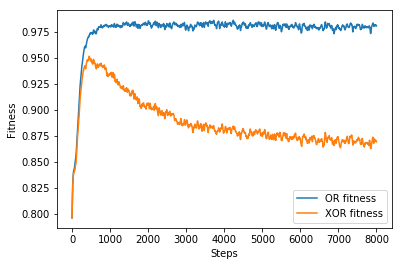

Initial Capacity:  1
Fixed Architecture:  True
Limit:  2


HBox(children=(IntProgress(value=0), HTML(value='')))


Average number of hidden neurons 2.0
Average number of steps 7999.0
Average OR Loss:  0.9960742616653442
Average XOR Loss:  0.964879822731018
Mean loss:  0.9804770421981811
Std loss:  0.015597219467163081
Fitness : 0.964879822731018


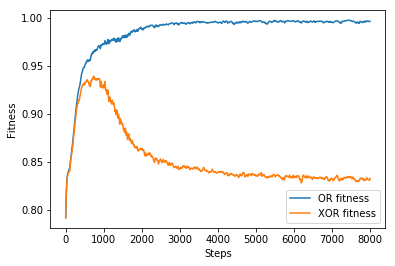

Initial Capacity:  2
Fixed Architecture:  True
Limit:  3


HBox(children=(IntProgress(value=0), HTML(value='')))


Average number of hidden neurons 3.0
Average number of steps 7999.0
Average OR Loss:  0.9994199240207672
Average XOR Loss:  0.9917515707015991
Mean loss:  0.9955857473611831
Std loss:  0.003834176659584021
Fitness : 0.9917515707015991


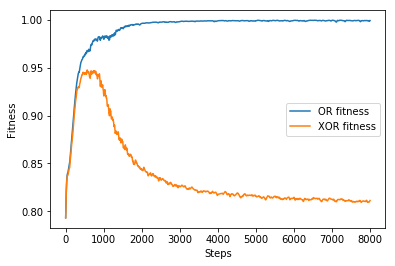

Initial Capacity:  1
Fixed Architecture:  True
Limit:  3


HBox(children=(IntProgress(value=0), HTML(value='')))


Average number of hidden neurons 2.99
Average number of steps 7930.53
Average OR Loss:  0.9999530053138733
Average XOR Loss:  0.9903178429603576
Mean loss:  0.9951354241371155
Std loss:  0.004817581176757846
Fitness : 0.9903178429603576


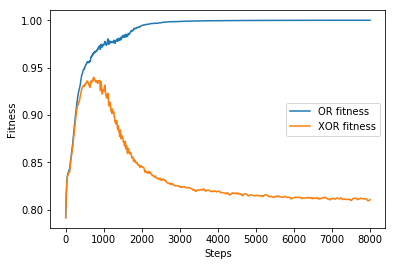

Initial Capacity:  1
Fixed Architecture:  True
Limit:  99999


HBox(children=(IntProgress(value=0), HTML(value='')))


Average number of hidden neurons 22.89
Average number of steps 7861.93
Average OR Loss:  0.9999937468767166
Average XOR Loss:  0.996187989115715
Mean loss:  0.9980908679962158
Std loss:  0.0019028788805007801
Fitness : 0.996187989115715


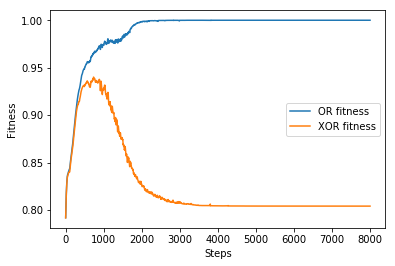

Initial Capacity:  2
Fixed Architecture:  True
Limit:  99999


HBox(children=(IntProgress(value=0), HTML(value='')))


Average number of hidden neurons 22.25
Average number of steps 7866.79
Average OR Loss:  0.9999949777126312
Average XOR Loss:  0.9962983548641204
Mean loss:  0.9981466662883758
Std loss:  0.0018483114242554
Fitness : 0.9962983548641204


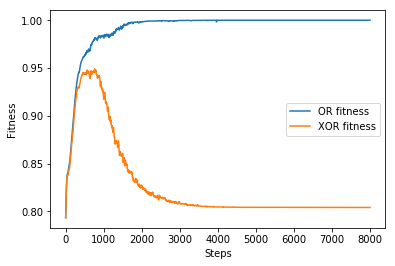

Initial Capacity:  3
Fixed Architecture:  True
Limit:  99999


HBox(children=(IntProgress(value=0), HTML(value='')))


Average number of hidden neurons 21.54
Average number of steps 7781.45
Average OR Loss:  0.9999872869253159
Average XOR Loss:  0.9942213249206543
Mean loss:  0.9971043059229852
Std loss:  0.002882981002330809
Fitness : 0.9942213249206544


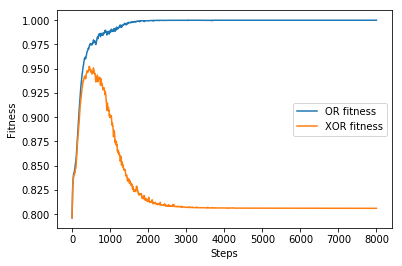

In [14]:
def train_both(initial_capacity, increase_cap, limit):
    exp3s = EXP3S(N, eta, beta, epsilon)

    net = network(3,copy.copy(initial_capacity),torch.sigmoid)
    optimizer = torch.optim.Adam(net.parameters(), lr=0.05)
    criterion = nn.MSELoss()

    history_unscaled_rewards = deque(maxlen=max_history_length)
    history_actions = []

    eval_OR = []
    eval_XOR = []

    best_loss = float('inf')
    no_improvement = 0

    for epoch in range(8000):
        optimizer.zero_grad()

        action = np.random.choice([i for i in range(N)], size=1, p=exp3s.sample_probabilities())[0]
        assert np.abs(np.sum(exp3s.sample_probabilities())-1.0)<0.001

        input_network, target = tasks[action][np.random.randint(4)]
        input_network = torch.tensor(input_network)
        target = torch.tensor(target)

        loss_before = criterion(net(input_network), target)
        loss_before.backward()
        optimizer.step()
        loss_after = criterion(net(input_network), target)

        nu_PG = (loss_before - loss_after).item()

        reward = scale_reward(nu_PG, history_unscaled_rewards)
        assert reward >=-1 and reward <=1

        history_unscaled_rewards.append(nu_PG)
        history_actions.append(action)

        exp3s.update_weights(reward, action)

        eval_loss_OR = criterion(net(Xs_OR),Ys_OR).item()
        eval_loss_XOR = criterion(net(Xs_XOR),Ys_OR).item()

        eval_OR.append(1.0/(1.0+eval_loss_OR))
        eval_XOR.append(1.0/(1.0+eval_loss_XOR))

        if np.mean([eval_loss_OR, eval_loss_XOR] - np.std([eval_loss_OR, eval_loss_XOR])) < best_loss*1.001:
            best_loss = np.mean([eval_loss_OR, eval_loss_XOR] - np.std([eval_loss_OR, eval_loss_XOR]))
            no_improvement = 0
        elif np.mean([1.0/(1.0+eval_loss_OR), 1.0/(1.0+eval_loss_XOR)] - np.std([1.0/(1.0+eval_loss_OR), 1.0/(1.0+eval_loss_XOR)])) > 0.999:
            break
        else:
            no_improvement += 1

        if no_improvement==100 and increase_cap and net.fc1.out_features < limit:
            net.increase_capacity(1)
            optimizer = torch.optim.Adam(net.parameters(), lr=0.05)
            best_loss = float('inf')
            no_improvement = 0

    return epoch, net.fc1.out_features, eval_OR, eval_XOR, net

def experiment(initial_capacity, fixed, limit):
    print('Initial Capacity: ', initial_capacity)
    print('Fixed Architecture: ', fixed)
    print('Limit: ', limit)
    seeds = 100
    
    criterion = nn.MSELoss()

    steps = 0
    hidden_neurons = 0

    plot_OR = np.zeros(8000)
    plot_XOR = np.zeros(8000)

    OR_loss = 0.0
    XOR_loss = 0.0

    for seed in tqdm_notebook(range(seeds)):
        np.random.seed(seed)
        torch.manual_seed(seed)
        step, hidden, OR_losses, XOR_losses, net = train_both(initial_capacity, fixed, limit)

        plot_OR[:step + 1] += OR_losses
        plot_XOR[:step + 1] += XOR_losses

        plot_OR[step + 1:] += np.array([OR_losses[-1]]*(8000-(step+1)))
        plot_XOR[step + 1:] += np.array([XOR_losses[-1]]*(8000-(step+1)))

        OR_loss += (1.0 / (1.0+criterion(net(Xs_OR),Ys_OR))).item()
        XOR_loss += (1.0 / (1.0+criterion(net(Xs_XOR),Ys_XOR))).item()

        steps += step
        hidden_neurons+=hidden

    plt.plot([i for i in range(8000)],plot_OR / float(seeds))
    plt.plot([i for i in range(8000)],plot_XOR / float(seeds))

    print('Average number of hidden neurons', hidden_neurons/seeds)
    print('Average number of steps', steps/seeds)
    print('Average OR Loss: ', OR_loss/seeds)
    print('Average XOR Loss: ', XOR_loss/seeds)
    print('Mean loss: ', np.mean([OR_loss/seeds, XOR_loss/seeds]))
    print('Std loss: ', np.std([OR_loss/seeds, XOR_loss/seeds]))
    print('Fitness :', np.mean([OR_loss/seeds, XOR_loss/seeds]) - np.std([OR_loss/seeds, XOR_loss/seeds]))
    plt.legend(['OR fitness', 'XOR fitness'])
    plt.xlabel('Steps')
    plt.ylabel('Fitness')
    plt.show()    

experiment(1, False, 1)
experiment(2, False, 2)
experiment(3, False, 3)

experiment(1, True, 2)
experiment(2, True, 3)
experiment(1, True, 3)

experiment(1, True, 99999)
experiment(2, True, 99999)
experiment(3, True, 99999)

"8" tasks. The subtasks of each task is now viewed as a separate task.

In [ ]:
# Settings from Graves et al.
N = 8
eta = 10e-3
beta = 0
epsilon = 0.05

max_history_length = 100

HBox(children=(IntProgress(value=0), HTML(value='')))

AttributeError: 'Adam' object has no attribute 'Adam'

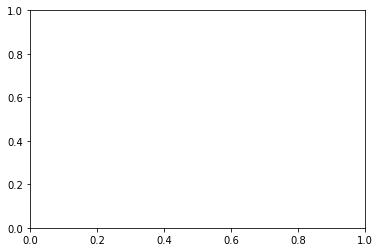

In [15]:
def experiment(initial_capacity, increase_cap):
    exp3s = EXP3S(N, 10e-3, 0, 0.05)

    net = network(3,copy.copy(initial_capacity),torch.sigmoid)
    optimizer = optim.Adam(net.parameters(), lr=0.05)
    criterion = nn.MSELoss()

    history_unscaled_rewards = deque(maxlen=max_history_length)
    history_actions = []

    eval_OR = []
    eval_XOR = []

    best_loss = float('inf')
    no_improvement = 0
    
    weight_history = []

    for epoch in range(8000):

        optimizer.zero_grad()
        #exp3s.sample_probabilities()
        action = np.random.choice([i for i in range(N)], size=1, p=exp3s.sample_probabilities())[0]
        assert np.abs(np.sum(exp3s.sample_probabilities())-1.0)<0.001
        
        weight_history.append(exp3s.sample_probabilities())

        input_network, target = tasks[action<4][action%4]
        input_network = torch.tensor(input_network)
        target = torch.tensor(target)

        loss_before = criterion(net(input_network), target)
        loss_before.backward()
        optimizer.step()
        loss_after = criterion(net(input_network), target)

        nu_PG = (loss_before - loss_after).item()

        reward = scale_reward(nu_PG, history_unscaled_rewards)
        assert reward >=-1 and reward <=1

        history_unscaled_rewards.append(nu_PG)
        history_actions.append(action)

        exp3s.update_weights(reward, action)

        eval_loss_OR = criterion(net(Xs_OR),Ys_OR).item()
        eval_loss_XOR = criterion(net(Xs_XOR),Ys_XOR).item()

        eval_OR.append(1.0/(1.0+eval_loss_OR))
        eval_XOR.append(1.0/(1.0+eval_loss_XOR))

        if np.mean([eval_loss_OR, eval_loss_XOR] - np.std([eval_loss_OR, eval_loss_XOR])) < best_loss*1.001:
            best_loss = np.mean([eval_loss_OR, eval_loss_XOR] - np.std([eval_loss_OR, eval_loss_XOR]))
            no_improvement = 0
        elif np.mean([1.0/(1.0+eval_loss_OR), 1.0/(1.0+eval_loss_XOR)] - np.std([1.0/(1.0+eval_loss_OR), 1.0/(1.0+eval_loss_XOR)])) > 0.999:
            break
        else:
            no_improvement += 1

        if no_improvement==100 and increase_cap:
            net.increase_capacity(1)
            optimizer = torch.optim.Adam(net.parameters(), lr=0.05)
            best_loss = float('inf')
            no_improvement = 0

    return epoch, net.fc1.out_features, eval_OR, eval_XOR, weight_history

seeds = 100
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

weight_history = np.zeros((8000, 8))
worst = 0
epochs = 0
OR_fitness = 0
XOR_fitness = 0

for seed in tqdm_notebook(range(seeds)):
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    epoch, hidden, OR_losses, XOR_losses, w_h = experiment(7, False)
    weight_history[:epoch+1] += w_h
    weight_history[epoch + 1:] += np.array([w_h[-1]]*(8000-(epoch+1)))
    if epoch>worst:
        worst = epoch
    epochs += epoch
    OR_fitness += OR_losses[-1]
    XOR_fitness += XOR_losses[-1]
    
weight_history = weight_history/seeds

print('Average epochs: ', epochs/seeds)
print('Average OR Fitness: ', OR_fitness/seeds)
print('Average XOR Fitness: ', XOR_fitness/seeds)
print('Average Fitness: ', np.mean([XOR_fitness/seeds, OR_fitness/seeds]))
print('Average Std: ', np.std([XOR_fitness/seeds, OR_fitness/seeds]))
print(weight_history[worst])
weight_history = weight_history[:worst+1]


plt.stackplot(range(weight_history.shape[0]), np.array(weight_history)[:,0], 
              np.array(weight_history)[:,1],
              np.array(weight_history)[:,2],
              np.array(weight_history)[:,3],
              np.array(weight_history)[:,4],
              np.array(weight_history)[:,5],
              np.array(weight_history)[:,6],
              np.array(weight_history)[:,7]
             ,labels=['0','1','2','3','4','5','6','7'])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], title='Line', loc='upper right', bbox_to_anchor=(1.2, 1.0))
plt.xlabel('Steps')
plt.ylabel('Weight distribution')
plt.margins(0,0)
plt.show()

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

weight_history = np.zeros((8000, 8))
worst = 0
epochs = 0
OR_fitness = 0
XOR_fitness = 0

for seed in tqdm_notebook(range(seeds)):
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    epoch, hidden, OR_losses, XOR_losses, w_h = experiment(1, True)
    weight_history[:epoch+1] += w_h
    weight_history[epoch + 1:] += np.array([w_h[-1]]*(8000-(epoch+1)))
    if epoch>worst:
        worst = epoch
    epochs += epoch
    OR_fitness += OR_losses[-1]
    XOR_fitness += XOR_losses[-1]
    
weight_history = weight_history/seeds

print('Average epochs: ', epochs/seeds)
print('Average OR Fitness: ', OR_fitness/seeds)
print('Average XOR Fitness: ', XOR_fitness/seeds)
print('Average Fitness: ', np.mean([XOR_fitness/seeds, OR_fitness/seeds]))
print('Average Std: ', np.std([XOR_fitness/seeds, OR_fitness/seeds]))
print(weight_history[worst])
weight_history = weight_history[:worst+1]
    

plt.stackplot(range(weight_history.shape[0]), np.array(weight_history)[:,0], 
              np.array(weight_history)[:,1],
              np.array(weight_history)[:,2],
              np.array(weight_history)[:,3],
              np.array(weight_history)[:,4],
              np.array(weight_history)[:,5],
              np.array(weight_history)[:,6],
              np.array(weight_history)[:,7]
             ,labels=['0','1','2','3','4','5','6','7'])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], title='Line', loc='upper right', bbox_to_anchor=(1.2, 1.0))
plt.xlabel('Steps')
plt.ylabel('Weight distribution')
plt.margins(0,0)
plt.show()

# Single example to show what subtask neurons are used for

In [ ]:
criterion = nn.MSELoss()

print('1,1')
net = network(3,2, torch.sigmoid)
net.fc1.weight.data = torch.tensor([[-13.9246, -14.4547,   0.1277],[3.9514,   3.9421,   3.2027]])
net.fc1.bias.data = torch.tensor([2.3548, -9.1569])
net.fc2.weight.data = torch.tensor([[-12.7663,  -8.5879]])
net.fc2.bias.data = torch.tensor([4.3873])

print('Unaltered')

print(net(Xs_OR))
print(1.0/(1.0+criterion(net(Xs_OR), Ys_OR)))
print(net(Xs_XOR))
print(1.0/(1.0+criterion(net(Xs_XOR),Ys_XOR)))

print('Removing added neurons')

net_decr = copy.deepcopy(net)
net_decr.decrease_capacity(1)

print(net_decr(Xs_OR))
print(1.0/(1.0+criterion(net_decr(Xs_OR), Ys_OR)))
print(net_decr(Xs_XOR))
print(1.0/(1.0+criterion(net_decr(Xs_XOR),Ys_XOR)))

print('---')

print(net_decr(Xs_OR[-1]))
print(1.0/(1.0+criterion(net_decr(Xs_OR[-1]), Ys_OR[-1])))
print(net_decr(Xs_XOR[-1]))
print(1.0/(1.0+criterion(net_decr(Xs_XOR[-1]),Ys_XOR[-1])))

print('Removing initial neurons')

net_decr_initial = copy.deepcopy(net)
net_decr_initial.decrease_capacity_initial(1)
print(net_decr_initial)

print(net_decr_initial(Xs_OR))
print(1.0/(1.0+criterion(net_decr_initial(Xs_OR), Ys_OR)))
print(net_decr_initial(Xs_XOR))
print(1.0/(1.0+criterion(net_decr_initial(Xs_XOR),Ys_XOR)))

print('---')

print(net_decr_initial(Xs_OR[-1]))
print(1.0/(1.0+criterion(net_decr_initial(Xs_OR[-1]), Ys_OR[-1])))
print(net_decr_initial(Xs_XOR[-1]))
print(1.0/(1.0+criterion(net_decr_initial(Xs_XOR[-1]),Ys_XOR[-1])))

print('2,1')
net = network(3,3, torch.sigmoid)
net.fc1.weight.data = torch.tensor([[16.8605, 16.9575, -1.5809],[17.3009, 17.4552, -1.6171],[4.1459,  4.1719,  3.3952]])
net.fc1.bias.data = torch.tensor([-6.2796, -6.4761, -9.7187])
net.fc2.weight.data = torch.tensor([[3.7117,  4.3500, -8.5934]])
net.fc2.bias.data = torch.tensor([-3.6135])

print('Unaltered')

print(net(Xs_OR))
print(1.0/(1.0+criterion(net(Xs_OR), Ys_OR)))
print(net(Xs_XOR))
print(1.0/(1.0+criterion(net(Xs_XOR),Ys_XOR)))

net_decr = copy.deepcopy(net)
net_decr.decrease_capacity(1)

print('Removing added neurons')

print(net_decr(Xs_OR))
print(1.0/(1.0+criterion(net_decr(Xs_OR), Ys_OR)))
print(net_decr(Xs_XOR))
print(1.0/(1.0+criterion(net_decr(Xs_XOR),Ys_XOR)))

print('---')

print(net_decr(Xs_OR[-1]))
print(1.0/(1.0+criterion(net_decr(Xs_OR[-1]), Ys_OR[-1])))
print(net_decr(Xs_XOR[-1]))
print(1.0/(1.0+criterion(net_decr(Xs_XOR[-1]),Ys_XOR[-1])))

print('Removing initial neurons')

net_decr_initial = copy.deepcopy(net)
net_decr_initial.decrease_capacity_initial(2)

print(net_decr_initial(Xs_OR))
print(1.0/(1.0+criterion(net_decr_initial(Xs_OR), Ys_OR)))
print(net_decr_initial(Xs_XOR))
print(1.0/(1.0+criterion(net_decr_initial(Xs_XOR),Ys_XOR)))

print('---')

print(net_decr_initial(Xs_OR[-1]))
print(1.0/(1.0+criterion(net_decr_initial(Xs_OR[-1]), Ys_OR[-1])))
print(net_decr_initial(Xs_XOR[-1]))
print(1.0/(1.0+criterion(net_decr_initial(Xs_XOR[-1]),Ys_XOR[-1])))

print('1,2')
net = network(3,3, torch.sigmoid)
net.fc1.weight.data = torch.tensor([[-13.3536, -14.1237,   0.1378],[4.6447,   4.7160,  -0.8880],[2.6883,   2.6957,   4.3787]])
net.fc1.bias.data = torch.tensor([2.6916, -5.8152, -7.9915])
net.fc2.weight.data = torch.tensor([[-13.1752,  -3.5194,  -6.3326]])
net.fc2.bias.data = torch.tensor([5.6768])

print('Unaltered')

print(net(Xs_OR))
print(1.0/(1.0+criterion(net(Xs_OR), Ys_OR)))
print(net(Xs_XOR))
print(1.0/(1.0+criterion(net(Xs_XOR),Ys_XOR)))

print('Removing added neurons')

net_decr = copy.deepcopy(net)
net_decr.decrease_capacity(2)

print(net_decr(Xs_OR))
print(1.0/(1.0+criterion(net_decr(Xs_OR), Ys_OR)))
print(net_decr(Xs_XOR))
print(1.0/(1.0+criterion(net_decr(Xs_XOR),Ys_XOR)))

print('----')

print(net_decr(Xs_OR[-1]))
print(1.0/(1.0+criterion(net_decr(Xs_OR[-1]), Ys_OR[-1])))
print(net_decr(Xs_XOR[-1]))
print(1.0/(1.0+criterion(net_decr(Xs_XOR[-1]),Ys_XOR[-1])))

print('Removing initial neurons')

net_decr_initial = copy.deepcopy(net)
net_decr_initial.decrease_capacity_initial(1)

print(net_decr_initial(Xs_OR))
print(1.0/(1.0+criterion(net_decr_initial(Xs_OR), Ys_OR)))
print(net_decr_initial(Xs_XOR))
print(1.0/(1.0+criterion(net_decr_initial(Xs_XOR),Ys_XOR)))

print('---')

print(net_decr_initial(Xs_OR[-1]))
print(1.0/(1.0+criterion(net_decr_initial(Xs_OR[-1]), Ys_OR[-1])))
print(net_decr_initial(Xs_XOR[-1]))
print(1.0/(1.0+criterion(net_decr_initial(Xs_XOR[-1]),Ys_XOR[-1])))

# Animation

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
Writer = animation.writers['ffmpeg']
writer = Writer(fps=24, metadata=dict(artist='Joe Harrison'), bitrate=1800)

In [ ]:
def train1_Both(iters, p, mode, delta, net, optim, writer, step_offset=0):
    criterion = nn.MSELoss()
    OR_losses = []
    XOR_losses = []
    average_losses = []
    
    x = np.linspace(0, 1.0, 100)
    y = np.linspace(0, 1.0, 100)
    
    OR_mat = np.zeros((100,100))
    XOR_mat = np.zeros((100,100))
    
    steps = 0
    for epoch in tqdm_notebook(range(iters)):
        r = np.random.choice([0,1,2,3], 1)
        if np.random.rand()<p:
            for X, Y in zip(Xs_OR[r], Ys_OR[r]):
                steps+=1
                optim.zero_grad()
                output = net(X.view(1,-1) + torch.FloatTensor(X.view(1,-1).size()).uniform_(-delta,delta))
                loss = criterion(output,Y.view(1,-1))
                
                loss.backward()
                optim.step()
                with torch.no_grad():
                    plt.clf()
                    plt.cla()
                    for idx_y, grid_point_y in enumerate(y):
                        for idx_x, grid_point_x in enumerate(x):
                            OR_mat[idx_y, idx_x] = net(torch.tensor([grid_point_x, grid_point_y, 0.0])).item()
                            XOR_mat[idx_y, idx_x] = net(torch.tensor([grid_point_x, grid_point_y, 1.0])).item()
                    
                    time.set_text('t=' + str(epoch + step_offset))
                    
                    plt.subplot(1, 2, 1)
                    plt.xticks(np.arange(min(x), max(x)+1, 0.5))
                    plt.yticks(np.arange(min(y), max(y)+1, 0.5))
                    plt.imshow(np.flip(1.0-OR_mat,0), interpolation='none', cmap='Greys', extent=(0.0, 1.0, 0.0, 1.0))
                    
                    plt.subplot(1, 2, 2)
                    plt.xticks(np.arange(min(x), max(x)+1, 0.5))
                    plt.yticks(np.arange(min(y), max(y)+1, 0.5))
                    plt.imshow(np.flip(1.0-XOR_mat,0), interpolation='none', cmap='Greys', extent=(0.0, 1.0, 0.0, 1.0))
                    
                    plt.savefig('./Animation/frame_{:6d}'.format(epoch + step_offset) + '.png')
                    
                    OR_loss = 1.0 / (1.0+criterion(net(Xs_OR),Ys_OR))
                    XOR_loss = 1.0 / (1.0+criterion(net(Xs_XOR),Ys_XOR))
                    average_loss = (OR_loss + XOR_loss)/2
                    
                    OR_losses.append(OR_loss)
                    XOR_losses.append(XOR_loss)
                    average_losses.append(average_loss)
                    
                    if mode==0:
                        if OR_loss > 1.0 - 0.001:
                            
                            return steps, net,optim
                    else:
                        if XOR_loss > 1.0 - 0.001:
                            
                            return steps, net,optim
        else:
            for X, Y in zip(Xs_XOR[r], Ys_XOR[r]):
                steps+=1
                optim.zero_grad()
                output = net(X.view(1,-1) + torch.FloatTensor(X.view(1,-1).size()).uniform_(-delta,delta))
                loss = criterion(output,Y.view(1,-1))
                
                loss.backward()
                optim.step()
                with torch.no_grad():
                    plt.clf()
                    plt.cla()
                    for idx_y, grid_point_y in enumerate(y):
                        for idx_x, grid_point_x in enumerate(x):
                            OR_mat[idx_y, idx_x] = net(torch.tensor([grid_point_x, grid_point_y, 0.0])).item()
                            XOR_mat[idx_y, idx_x] = net(torch.tensor([grid_point_x, grid_point_y, 1.0])).item()
                    
                    
                    time.set_text('t=' + str(epoch + step_offset))
                    
                    plt.subplot(1, 2, 1)
                    plt.xticks(np.arange(min(x), max(x)+1, 0.5))
                    plt.yticks(np.arange(min(y), max(y)+1, 0.5))
                    plt.imshow(np.flip(1.0-OR_mat,0), interpolation='none', cmap='Greys', extent=(0.0, 1.0, 0.0, 1.0))
                    
                    plt.subplot(1, 2, 2)
                    plt.xticks(np.arange(min(x), max(x)+1, 0.5))
                    plt.yticks(np.arange(min(y), max(y)+1, 0.5))
                    plt.imshow(np.flip(1.0-XOR_mat, 0), interpolation='none', cmap='Greys', extent=(0.0, 1.0, 0.0, 1.0))
                    
                    plt.savefig('./Animation/frame_{:6d}'.format(epoch + step_offset) + '.png')
                
                    OR_loss = 1.0 / (1.0+criterion(net(Xs_OR),Ys_OR))
                    XOR_loss = 1.0 / (1.0+criterion(net(Xs_XOR),Ys_XOR))
                    average_loss = (OR_loss + XOR_loss)/2
                    
                    OR_losses.append(OR_loss)
                    XOR_losses.append(XOR_loss)
                    average_losses.append(average_loss)
                    
                    if mode==0:
                        if OR_loss > 1.0 - 0.001:
                            
                            return steps, net,optim
                    else:
                        if XOR_loss > 1.0 - 0.001:
                            
                            return steps, net,optim
                        
    return steps, net, optim

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)
axtext = fig.add_axes([0.0,0.95,0.1,0.05])
axtext.axis("off")
time = axtext.text(0.5,0.5, str(0), ha="left", va="top")


with writer.saving(fig, 'xor.mp4' ,100):
    x = np.linspace(0, 1.0, 100)
    y = np.linspace(0, 1.0, 100)
    
    np.random.seed(43)
    torch.manual_seed(43)
    net = network(3,1, torch.sigmoid)
    optim = torch.optim.Adam(net.parameters(), lr=0.05)
    criterion = nn.MSELoss()
    
    step, net, optim = train1_Both(4000, 0.9, 0, 0.0, net, optim, writer)
    net.increase_capacity(1)
    optim = torch.optim.Adam(net.parameters(),lr=0.05)
    step, net, optim = train1_Both(4000, 0.1, 1, 0.0, net, optim, writer, step)